In [34]:
import pickle

# Путь к файлу
file_path = '/Users/makssinitskiy/Desktop/MapGenerator-dev/data/game_maps_dataset.pkl'

# Загружаем данные
with open(file_path, 'rb') as f:
    data = pickle.load(f)

# Выводим структуру данных
print("Тип данных:", type(data))
if isinstance(data, dict):
    print("Ключи:", list(data.keys()))
    for key in data:
        print(f"\nКлюч '{key}' | Тип: {type(data[key])} | Размер: {len(data[key]) if hasattr(data[key], '__len__') else '---'}")
        print("Пример:", data[key][:2])
else:
    print("Данные не в формате словаря. Пример:", data[:2])

Тип данных: <class 'dict'>
Ключи: ['object_nums', 'positions', 'maps']

Ключ 'object_nums' | Тип: <class 'list'> | Размер: 1000
Пример: [[1, 1, 1, 2, 0], [1, 1, 1, 2, 0]]

Ключ 'positions' | Тип: <class 'list'> | Размер: 1000
Пример: [{'player': [(1, 3)], 'key': [(7, 8)], 'door': [(5, 12)], 'enemy1': [(6, 1), (4, 6)]}, {'player': [(7, 9)], 'key': [(10, 6)], 'door': [(7, 5)], 'enemy1': [(4, 5), (3, 8)]}]

Ключ 'maps' | Тип: <class 'list'> | Размер: 1000
Пример: [array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 0, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1],
       [1, 0, 0, 0, 0, 0, 5, 0, 0, 1, 0, 0, 0, 1],
       [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1],
       [1, 5, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 1, 1],
       [1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1],
       [1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1],
       [1, 1, 1, 0, 0, 0

In [35]:
import numpy as np

def one_hot_encode_level(level, num_classes=6):
    height, width = level.shape
    encoded = np.zeros((height, width, num_classes))
    for i in range(num_classes):
        encoded[:, :, i] = (level == i)
    return encoded

# Пример использования
one_hot_maps = [one_hot_encode_level(np.array(m), num_classes=6) for m in data['maps']]
one_hot_maps = np.array(one_hot_maps)

In [36]:
def generate_description_from_positions(positions_dict):
    description = "A map with "
    elements = []

    player_pos = positions_dict.get('player', [])
    if len(player_pos) > 0:
        elements.append(f"player at {player_pos[0]}")

    key_pos = positions_dict.get('key', [])
    if len(key_pos) > 0:
        elements.append(f"{len(key_pos)} key(s)")

    door_pos = positions_dict.get('door', [])
    if len(door_pos) > 0:
        elements.append(f"{len(door_pos)} door(s)")

    enemy_pos = positions_dict.get('enemy1', [])
    if len(enemy_pos) > 0:
        elements.append(f"{len(enemy_pos)} enemy(ies)")

    if not elements:
        description += "nothing."
    else:
        description += ", ".join(elements) + "."
    return description

descriptions = [generate_description_from_positions(pos) for pos in data['positions']]

In [37]:
from transformers import CLIPTokenizer, CLIPModel
import torch

# Загрузка модели CLIP
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

# Функция для получения эмбеддингов
def get_clip_embeddings(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = clip_model.get_text_features(**inputs)
    return outputs.numpy()

embeddings = get_clip_embeddings(descriptions)

In [38]:
np.save("processed_game_maps.npy", {
    "images": one_hot_maps,
    "labels": descriptions,
    "embeddings": embeddings
})
print("Данные сохранены в processed_game_maps.npy")

Данные сохранены в processed_game_maps.npy


In [39]:
import numpy as np
import pickle
from transformers import CLIPTokenizer, CLIPModel
import torch
from sklearn.model_selection import train_test_split
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, UpSampling2D, Conv2D, Add, BatchNormalization, Concatenate, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import textwrap
from PIL import Image
import os
from tqdm import tqdm

In [40]:
class ConditionalInstanceNormalization(Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super(ConditionalInstanceNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon

    def call(self, inputs):
        conv, scale, bias = inputs
        mean, variance = tf.nn.moments(conv, axes=[1, 2], keepdims=True)
        normalized_output = (conv - mean) / tf.sqrt(variance + self.epsilon)
        normalized_output *= scale[:, tf.newaxis, tf.newaxis]
        normalized_output += bias[:, tf.newaxis, tf.newaxis]
        return normalized_output


class FiLMLayer(Layer):
    def __init__(self):
        super(FiLMLayer, self).__init__()

    def call(self, inputs):
        ft, film_params = inputs
        runtime_shape = tf.shape(ft)
        height, width, feature_size = runtime_shape[1], runtime_shape[2], runtime_shape[3]
        film_params = tf.expand_dims(film_params, axis=[1])
        film_params = tf.expand_dims(film_params, axis=[1])
        film_params = tf.tile(film_params, [1, height, width, 1])
        gammas = film_params[:, :, :, :feature_size]
        betas = film_params[:, :, :, feature_size:]
        output = (1 + gammas) * ft + betas
        return output


class DollarModel:
    def __init__(self, model_name, img_shape, lr, data_path, dataset_type,
                 embedding_dim=128, z_dim=5, kern_size=7, filter_count=128,
                 num_res_blocks=3, condition_type='FiLM'):

        self.embedding_dim = embedding_dim
        self.img_shape = img_shape
        self.model_name = model_name
        self.z_dim = z_dim
        self.data_path = data_path
        self.filter_count = filter_count
        self.kern_size = kern_size
        self.dataset_type = dataset_type
        self.num_res_blocks = num_res_blocks
        self.condition_type = condition_type
        self.lr = lr
        self.model_path = f'models/{self.model_name}/'
        os.makedirs(self.model_path, exist_ok=True)

        self.load_data()
        if dataset_type == 'map':
            self.num_upsample = 2
            self.gen_to_image = self.map_to_image
        else:
            self.num_upsample = 1
            self.gen_to_image = self.sprite_to_image

        self.create_model()

    def create_model(self):
        noise = Input(shape=(self.z_dim,))
        embedding = Input(shape=(self.embedding_dim,))

        x = Dense(self.filter_count * 4 * 4)(noise)
        x = Reshape((4, 4, self.filter_count))(x)

        for i in range(self.num_res_blocks):
            if i < self.num_upsample:
                x = UpSampling2D()(x)
            x1 = Conv2D(self.filter_count, self.kern_size, padding="same", activation="relu")(x)
            x1 = BatchNormalization()(x1)
            x1 = Conv2D(self.filter_count, self.kern_size, padding="same", activation="relu")(x1)
            x1 = BatchNormalization()(x1)
            x = Add()([x, x1])

            if self.condition_type == 'CIN':
                scale = Dense(self.filter_count)(embedding)
                bias = Dense(self.filter_count)(embedding)
                x = ConditionalInstanceNormalization()([x, scale, bias])
            elif self.condition_type == 'FiLM':
                film_params = Dense(2 * self.filter_count)(embedding)
                x = FiLMLayer()([x, film_params])

        x = Conv2D(self.channels, kernel_size=9, padding="same", activation="softmax")(x)
        self.generator = Model([noise, embedding], x, name="Generator")
        self.generator.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=self.lr), metrics=['accuracy'])

    def load_data(self):
        data = np.load(self.data_path, allow_pickle=True).item()
        self.images = np.array(data['images'])
        self.labels = list(data['labels'])
        self.embeddings = np.array(data['embeddings'])

        self.channels = self.images.shape[-1]

    def map_to_image(self, ascii_map):
        decoded = np.argmax(ascii_map, axis=-1)
        return Image.fromarray(decoded.astype('uint8'))

    def sprite_to_image(self, image):
        return Image.fromarray(np.argmax(image, axis=-1).astype('uint8'))

In [41]:
def train(model, epochs=100, batch_size=32, sample_interval=10):
    for epoch in range(epochs):
        idx = np.random.randint(0, len(model.images), batch_size)
        imgs = model.images[idx]
        embs = model.embeddings[idx]

        noise = np.random.normal(0, 1, (batch_size, model.z_dim))
        loss = model.generator.train_on_batch([noise, embs], imgs)

        if epoch % sample_interval == 0:
            print(f"Epoch: {epoch}, Loss: {loss[0]:.4f}, Accuracy: {loss[1]:.4f}")
            generate_level(model, embs[0])

In [42]:
def generate_level(model, description_embedding, num_samples=1):
    noise = np.random.normal(0, 1, (num_samples, model.z_dim))
    emb = np.repeat([description_embedding], num_samples, axis=0)
    pred = model.generator.predict([noise, emb], verbose=0)
    gen = np.argmax(pred, axis=-1)[0]


In [44]:
class ConditionalInstanceNormalization(Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super(ConditionalInstanceNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon

    def call(self, inputs):
        conv, scale, bias = inputs
        mean, variance = tf.nn.moments(conv, axes=[1, 2], keepdims=True)
        normalized_output = (conv - mean) / tf.sqrt(variance + self.epsilon)
        normalized_output *= scale[:, tf.newaxis, tf.newaxis]
        normalized_output += bias[:, tf.newaxis, tf.newaxis]
        return normalized_output


class FiLMLayer(Layer):
    def __init__(self):
        super(FiLMLayer, self).__init__()

    def call(self, inputs):
        ft, film_params = inputs
        runtime_shape = tf.shape(ft)
        height, width, feature_size = runtime_shape[1], runtime_shape[2], runtime_shape[3]
        film_params = tf.expand_dims(film_params, axis=[1])
        film_params = tf.expand_dims(film_params, axis=[1])
        film_params = tf.tile(film_params, [1, height, width, 1])
        gammas = film_params[:, :, :, :feature_size]
        betas = film_params[:, :, :, feature_size:]
        output = (1 + gammas) * ft + betas
        return output


class DollarModel:
    def __init__(self, model_name, img_shape, lr, data_path, dataset_type,
                 embedding_dim=128, z_dim=5, kern_size=7, filter_count=128,
                 num_res_blocks=3, condition_type='FiLM'):

        self.embedding_dim = embedding_dim
        self.img_shape = img_shape
        self.model_name = model_name
        self.z_dim = z_dim
        self.data_path = data_path
        self.filter_count = filter_count
        self.kern_size = kern_size
        self.dataset_type = dataset_type
        self.num_res_blocks = num_res_blocks
        self.condition_type = condition_type
        self.lr = lr
        self.model_path = f'models/{self.model_name}/'
        os.makedirs(self.model_path, exist_ok=True)

        self.load_data()
        if dataset_type == 'map':
            self.num_upsample = 2
            self.gen_to_image = self.map_to_image
        else:
            self.num_upsample = 1
            self.gen_to_image = self.sprite_to_image

        self.create_model()

    def create_model(self):
        noise = Input(shape=(self.z_dim,))
        embedding = Input(shape=(self.embedding_dim,))

        x = Dense(self.filter_count * 4 * 4)(noise)
        x = Reshape((4, 4, self.filter_count))(x)

        for i in range(self.num_res_blocks):
            if i < self.num_upsample:
                x = UpSampling2D()(x)
            x1 = Conv2D(self.filter_count, self.kern_size, padding="same", activation="relu")(x)
            x1 = BatchNormalization()(x1)
            x1 = Conv2D(self.filter_count, self.kern_size, padding="same", activation="relu")(x1)
            x1 = BatchNormalization()(x1)
            x = Add()([x, x1])

            if self.condition_type == 'CIN':
                scale = Dense(self.filter_count)(embedding)
                bias = Dense(self.filter_count)(embedding)
                x = ConditionalInstanceNormalization()([x, scale, bias])
            elif self.condition_type == 'FiLM':
                film_params = Dense(2 * self.filter_count)(embedding)
                x = FiLMLayer()([x, film_params])

        x = Conv2D(self.channels, kernel_size=9, padding="same", activation="softmax")(x)
        self.generator = Model([noise, embedding], x, name="Generator")
        self.generator.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=self.lr), metrics=['accuracy'])

    def load_data(self):
        data = np.load(self.data_path, allow_pickle=True).item()
        self.images = np.array(data['images'])
        self.labels = list(data['labels'])
        self.embeddings = np.array(data['embeddings'])

        self.channels = self.images.shape[-1]

    def map_to_image(self, ascii_map):
        decoded = np.argmax(ascii_map, axis=-1)
        return Image.fromarray(decoded.astype('uint8'))

    def sprite_to_image(self, image):
        return Image.fromarray(np.argmax(image, axis=-1).astype('uint8'))

In [45]:
def train(model, epochs=100, batch_size=32, sample_interval=10):
    for epoch in range(epochs):
        idx = np.random.randint(0, len(model.images), batch_size)
        imgs = model.images[idx]
        embs = model.embeddings[idx]

        noise = np.random.normal(0, 1, (batch_size, model.z_dim))
        loss = model.generator.train_on_batch([noise, embs], imgs)

        if epoch % sample_interval == 0:
            print(f"Epoch: {epoch}, Loss: {loss[0]:.4f}, Accuracy: {loss[1]:.4f}")
            generate_level(model, embs[0])

def generate_level(model, description_embedding, num_samples=1):
    noise = np.random.normal(0, 1, (num_samples, model.z_dim))
    emb = np.repeat([description_embedding], num_samples, axis=0)
    pred = model.generator.predict([noise, emb], verbose=0)
    gen = np.argmax(pred, axis=-1)[0]

In [46]:
import numpy as np
import pickle
import torch
from transformers import CLIPTokenizer, CLIPModel
import tensorflow as tf

# === 1. Загрузка данных ===
file_path = '/Users/makssinitskiy/Desktop/MapGenerator-dev/data/game_maps_dataset.pkl'

with open(file_path, 'rb') as f:
    data = pickle.load(f)

print("Данные загружены!")


# === 2. One-hot кодирование карт ===
def one_hot_encode_level(level, num_classes=6):
    h, w = level.shape
    encoded = np.zeros((h, w, num_classes))
    for i in range(num_classes):
        encoded[:, :, i] = (level == i)
    return encoded

one_hot_maps = [one_hot_encode_level(np.array(m), num_classes=6) for m in data['maps']]
one_hot_maps = np.array(one_hot_maps)
print("One-hot кодирование выполнено:", one_hot_maps.shape)


# === 3. Генерация текстовых описаний ===
def generate_description_from_positions(positions_dict):
    elements = []
    if 'player' in positions_dict and len(positions_dict['player']) > 0:
        elements.append("player")
    if 'key' in positions_dict and len(positions_dict['key']) > 0:
        elements.append(f"{len(positions_dict['key'])} keys")
    if 'door' in positions_dict and len(positions_dict['door']) > 0:
        elements.append(f"{len(positions_dict['door'])} doors")
    if 'enemy1' in positions_dict and len(positions_dict['enemy1']) > 0:
        elements.append(f"{len(positions_dict['enemy1'])} enemies")
    return "A game level with " + ", ".join(elements) if elements else "An empty level"

descriptions = [generate_description_from_positions(pos) for pos in data['positions']]
print("Описания созданы:", len(descriptions))


# === 4. Получение эмбеддингов через правильную модель ===
# Используем модель, которая выдает 768-мерные эмбеддинги
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

def get_clip_embeddings(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = clip_model.get_text_features(**inputs)
    return outputs.numpy()

embeddings = get_clip_embeddings(descriptions)
print("Эмбеддинги получены:", embeddings.shape)  # должно быть (N, 512) или (N, 768)


# === 5. Изменение размера до 16x16 через tf.image.resize ===
def resize_image(img, target_size=(16, 16)):
    return tf.image.resize(img, size=target_size).numpy()

one_hot_maps_resized = np.array([resize_image(img, (16, 16)) for img in one_hot_maps])
print("Размер изменён:", one_hot_maps_resized.shape)


# === 6. Сохранение обработанного датасета ===
np.save("processed_game_maps.npy", {
    "images": one_hot_maps_resized,
    "labels": descriptions,
    "embeddings": embeddings
})
print("Датасет сохранён!")


# === 7. Обучение модели ===
input_shape = one_hot_maps_resized[0].shape
embedding_dim = embeddings.shape[1]  # должно быть 512

model = DollarModel(
    model_name="clip_map_generator",
    img_shape=input_shape,
    lr=0.0002,
    data_path="processed_game_maps.npy",
    dataset_type='map',
    embedding_dim=embedding_dim,  # Теперь корректно: 512
    z_dim=5,
    filter_count=128,
    kern_size=5,
    num_res_blocks=3,
    condition_type='FiLM'
)

print("Модель создана!")

# === 8. Запуск обучения ===
train(model, epochs=100, batch_size=32, sample_interval=10)

Данные загружены!
One-hot кодирование выполнено: (1000, 14, 14, 6)
Описания созданы: 1000
Эмбеддинги получены: (1000, 512)
Размер изменён: (1000, 16, 16, 6)
Датасет сохранён!
Модель создана!
Epoch: 0, Loss: 4.0389, Accuracy: 0.1761
Epoch: 10, Loss: 1.4580, Accuracy: 0.6047
Epoch: 20, Loss: 1.1860, Accuracy: 0.6390
Epoch: 30, Loss: 1.0373, Accuracy: 0.6577
Epoch: 40, Loss: 0.9443, Accuracy: 0.6703
Epoch: 50, Loss: 0.8820, Accuracy: 0.6791
Epoch: 60, Loss: 0.8375, Accuracy: 0.6861
Epoch: 70, Loss: 0.8040, Accuracy: 0.6917
Epoch: 80, Loss: 0.7781, Accuracy: 0.6963
Epoch: 90, Loss: 0.7572, Accuracy: 0.6993


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


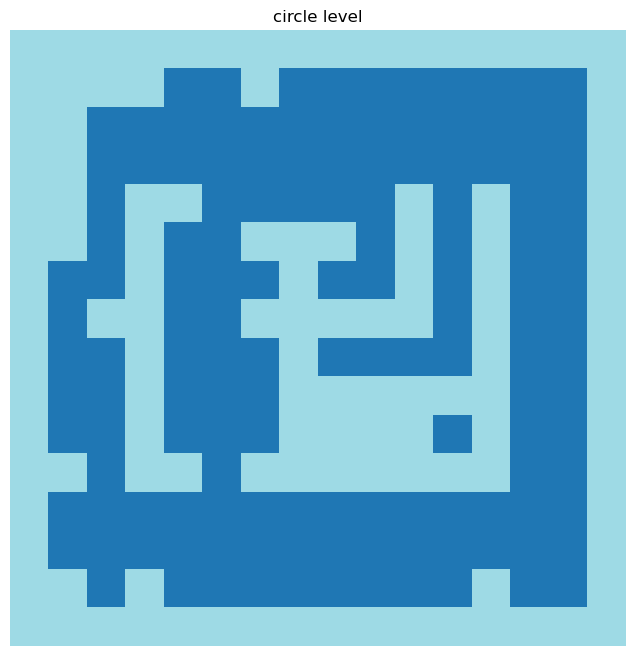

Сгенерированная карта:
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 1]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 1 0 1 1 0 0 0 0 0 1 0 1 0 0 1]
 [1 1 0 1 0 0 1 1 1 0 1 0 1 0 0 1]
 [1 0 0 1 0 0 0 1 0 0 1 0 1 0 0 1]
 [1 0 1 1 0 0 1 1 1 1 1 0 1 0 0 1]
 [1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1]
 [1 0 0 1 0 0 0 1 1 1 1 1 1 0 0 1]
 [1 0 0 1 0 0 0 1 1 1 1 0 1 0 0 1]
 [1 1 0 1 1 0 1 1 1 1 1 1 1 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]


In [50]:
import numpy as np
import matplotlib.pyplot as plt
import textwrap
from transformers import CLIPTokenizer
# Загрузка весов обученной модели
#model.generator.load_weights("models/clip_map_generator/generator_final.h5")  # Укажите путь к сохранённым весам

# === Функция инференса ===
def generate_level_from_text(text_description):
    # 1. Получаем эмбеддинг текста
    tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
    inputs = tokenizer(text_description, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        embedding = clip_model.get_text_features(**inputs).numpy()
    
    # 2. Генерируем шум
    noise = np.random.normal(0, 1, (1, model.z_dim))  # 1 сэмпл
    
    # 3. Получаем предсказание от генератора
    generated_probs = model.generator.predict([noise, embedding])
    generated_level = np.argmax(generated_probs[0], axis=-1)  # (16, 16) матрица классов
    
    # 4. Визуализация
    plt.figure(figsize=(8, 8))
    plt.imshow(generated_level, cmap='tab20')
    plt.title("\n".join(textwrap.wrap(text_description, 30)), fontsize=12)
    plt.axis('off')
    plt.show()
    
    return generated_level

# === Пример использования ===
text = "circle level"
generated_map = generate_level_from_text(text)
print("Сгенерированная карта:")
print(generated_map)

Данные загружены!
One-hot кодирование выполнено: (1000, 14, 14, 6)
Описания созданы: 1000
Эмбеддинги получены: (1000, 512)
Размер изменён: (1000, 16, 16, 6)
Датасет сохранён!
Модель создана!
Epoch: 0, Loss: 4.3129, Accuracy: 0.1176


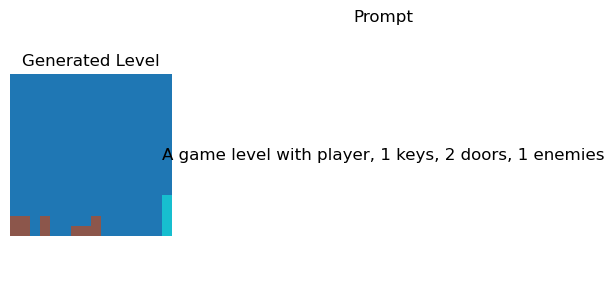

Epoch: 10, Loss: 1.4677, Accuracy: 0.5995


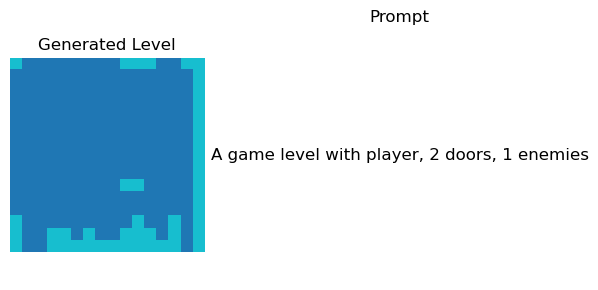

Epoch: 20, Loss: 1.1779, Accuracy: 0.6418


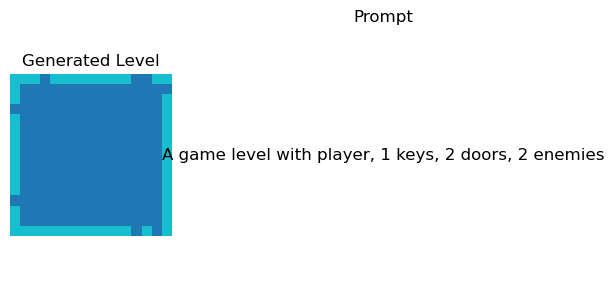

Epoch: 30, Loss: 1.0325, Accuracy: 0.6612


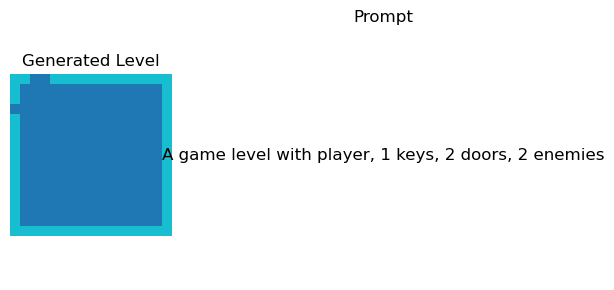

Epoch: 40, Loss: 0.9418, Accuracy: 0.6722


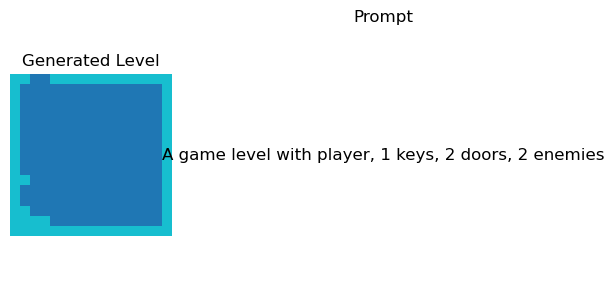

Epoch: 50, Loss: 0.8821, Accuracy: 0.6808


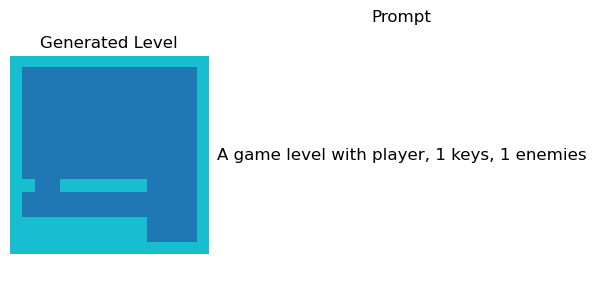

Epoch: 60, Loss: 0.8383, Accuracy: 0.6870


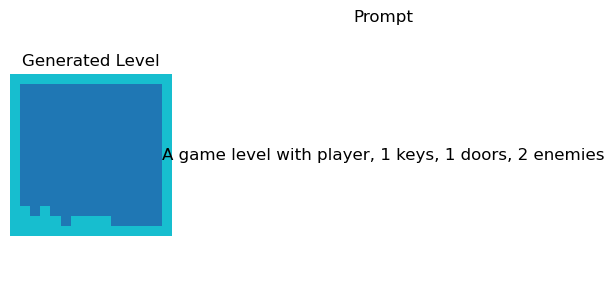

Epoch: 70, Loss: 0.8059, Accuracy: 0.6927


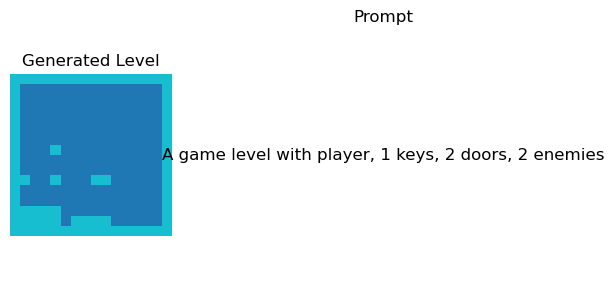

Epoch: 80, Loss: 0.7803, Accuracy: 0.6961


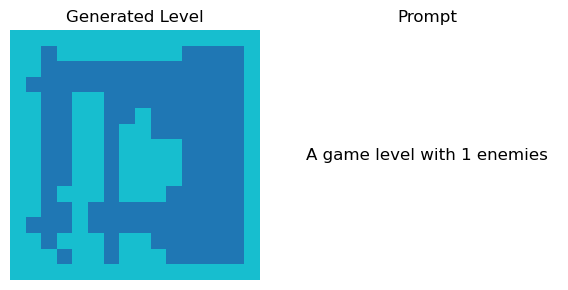

Epoch: 90, Loss: 0.7590, Accuracy: 0.6997


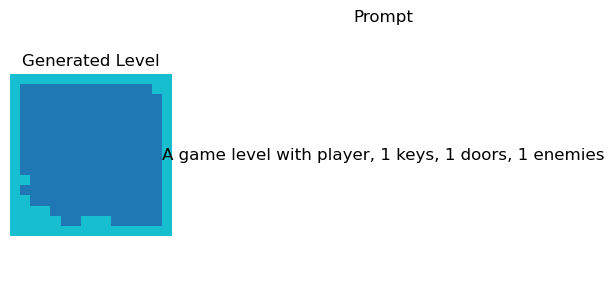

Epoch: 100, Loss: 0.7418, Accuracy: 0.7021


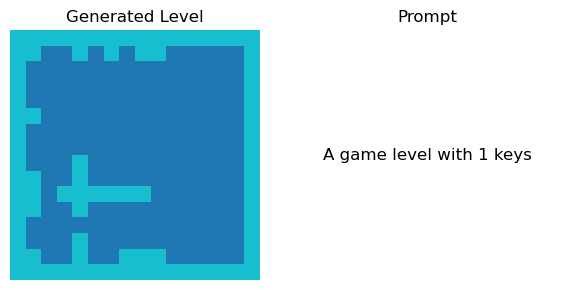

Epoch: 110, Loss: 0.7277, Accuracy: 0.7047


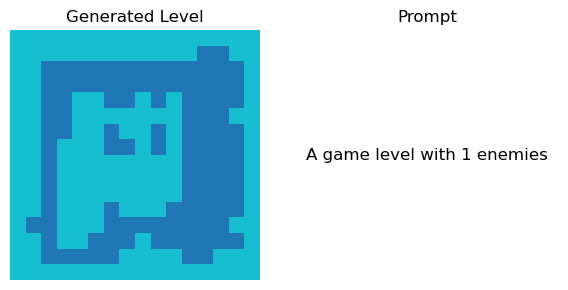

Epoch: 120, Loss: 0.7156, Accuracy: 0.7067


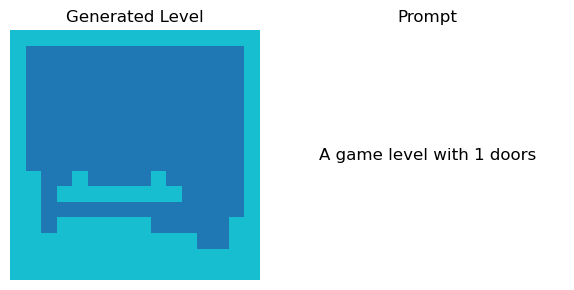

Epoch: 130, Loss: 0.7050, Accuracy: 0.7088


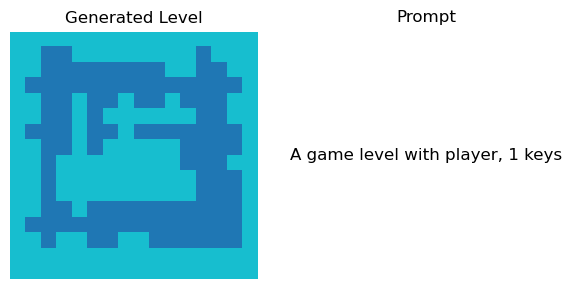

Epoch: 140, Loss: 0.6952, Accuracy: 0.7106


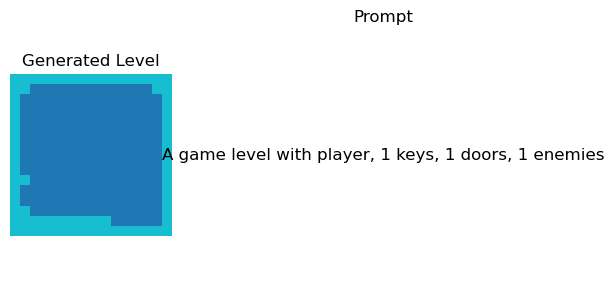

Epoch: 150, Loss: 0.6874, Accuracy: 0.7121


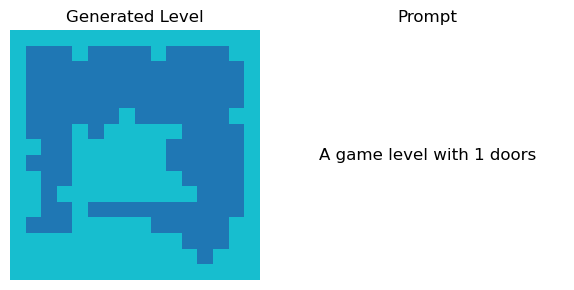

Epoch: 160, Loss: 0.6805, Accuracy: 0.7131


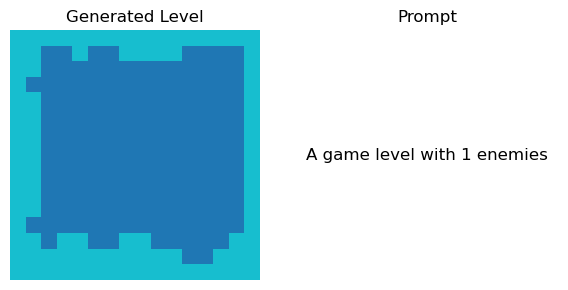

Epoch: 170, Loss: 0.6743, Accuracy: 0.7142


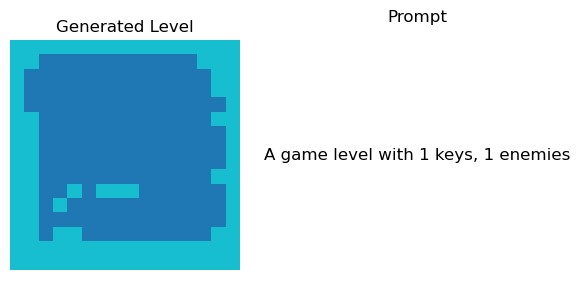

Epoch: 180, Loss: 0.6684, Accuracy: 0.7154


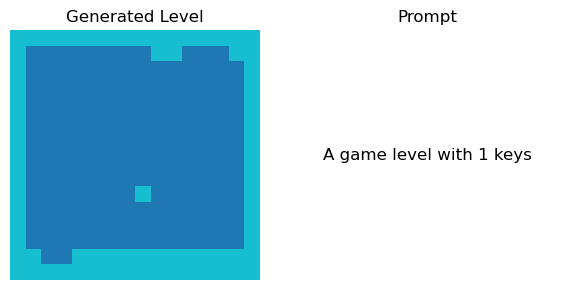

Epoch: 190, Loss: 0.6636, Accuracy: 0.7162


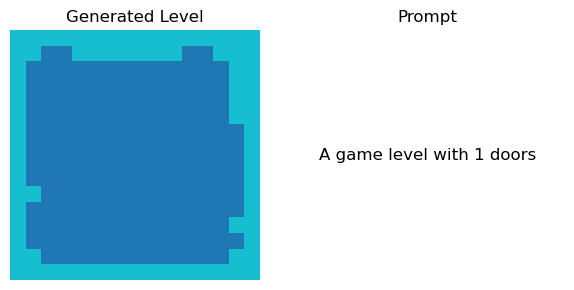

Epoch: 200, Loss: 0.6589, Accuracy: 0.7173


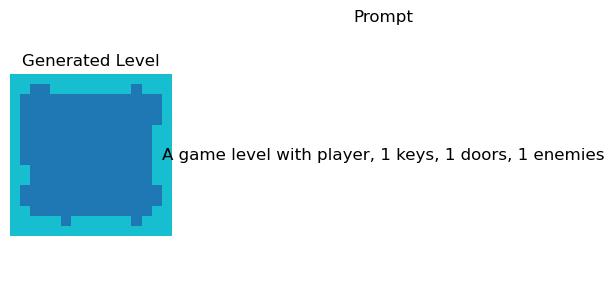

Epoch: 210, Loss: 0.6548, Accuracy: 0.7179


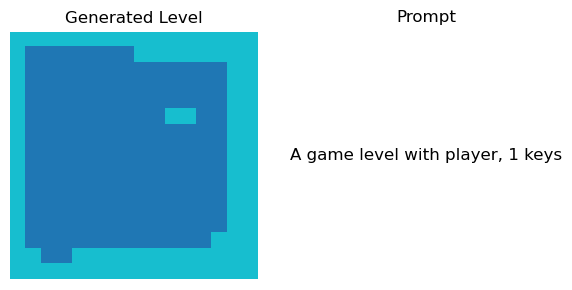

Epoch: 220, Loss: 0.6506, Accuracy: 0.7191


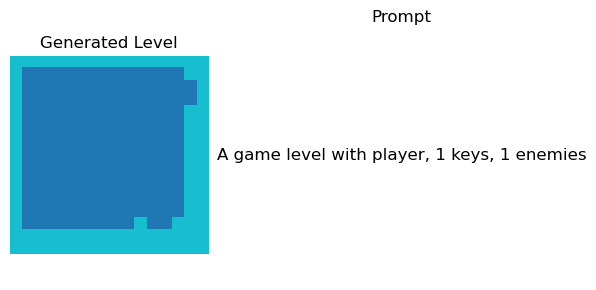

Epoch: 230, Loss: 0.6472, Accuracy: 0.7197


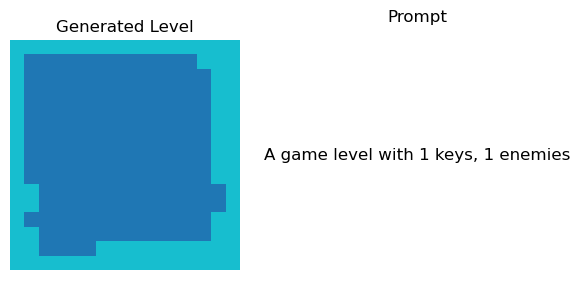

Epoch: 240, Loss: 0.6438, Accuracy: 0.7206


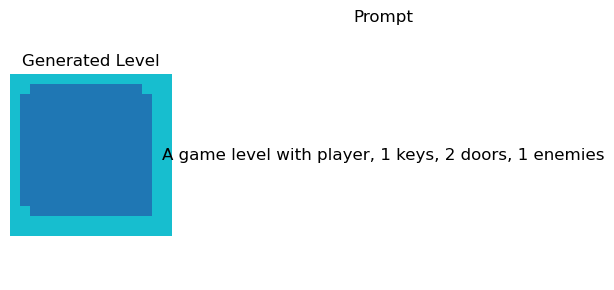

Epoch: 250, Loss: 0.6411, Accuracy: 0.7212


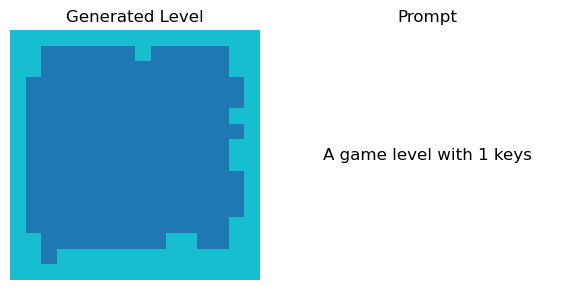

Epoch: 260, Loss: 0.6383, Accuracy: 0.7219


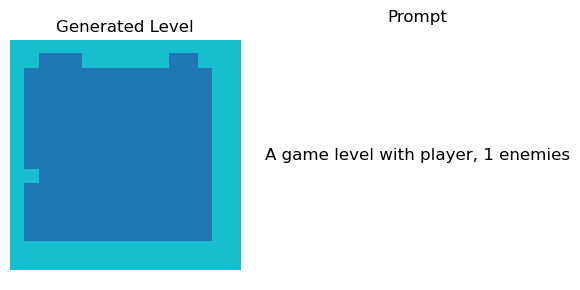

Epoch: 270, Loss: 0.6355, Accuracy: 0.7225


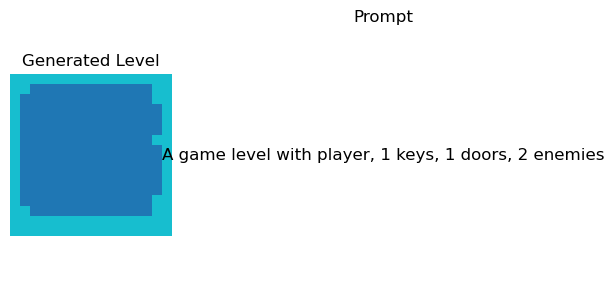

Epoch: 280, Loss: 0.6328, Accuracy: 0.7230


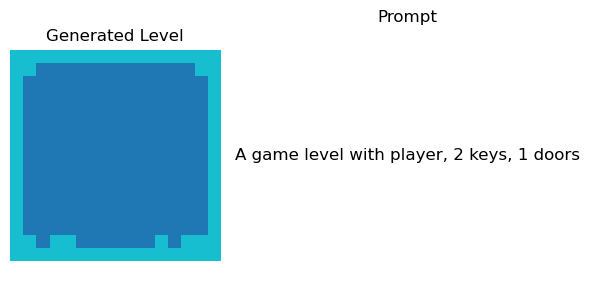

Epoch: 290, Loss: 0.6305, Accuracy: 0.7234


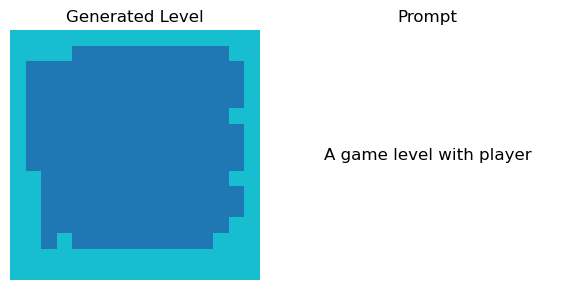

Epoch: 300, Loss: 0.6285, Accuracy: 0.7239


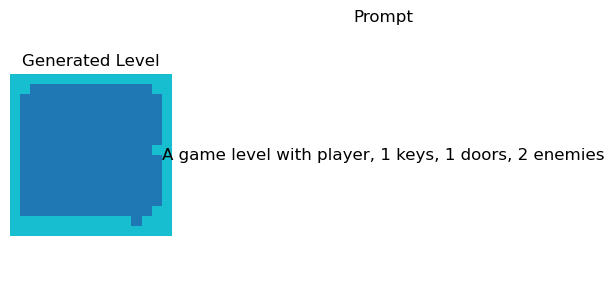

Epoch: 310, Loss: 0.6265, Accuracy: 0.7245


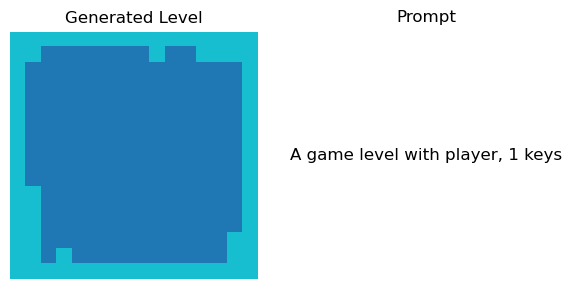

Epoch: 320, Loss: 0.6245, Accuracy: 0.7250


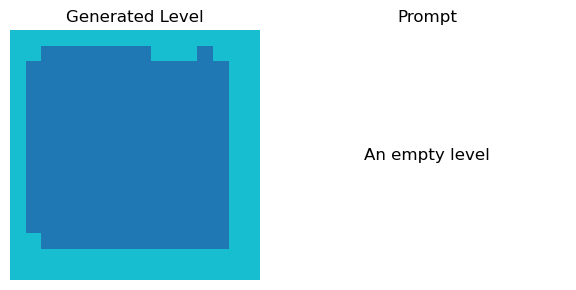

Epoch: 330, Loss: 0.6227, Accuracy: 0.7254


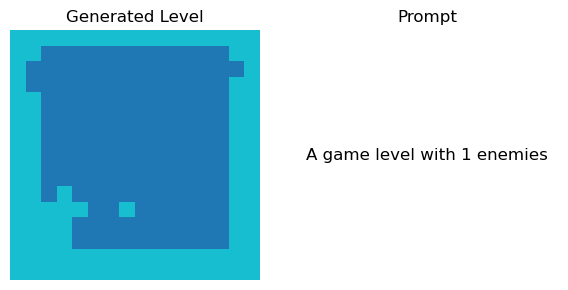

Epoch: 340, Loss: 0.6210, Accuracy: 0.7258


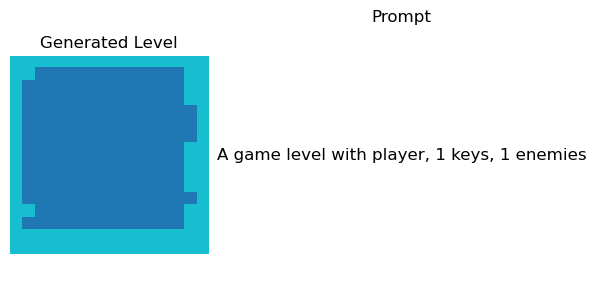

Epoch: 350, Loss: 0.6195, Accuracy: 0.7261


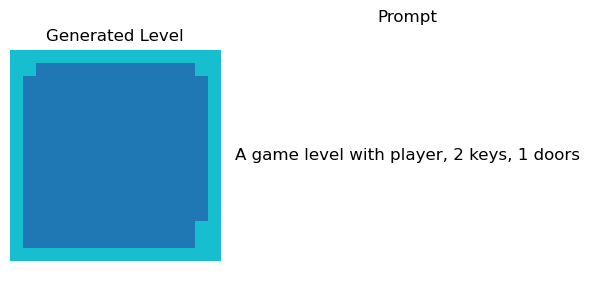

Epoch: 360, Loss: 0.6178, Accuracy: 0.7263


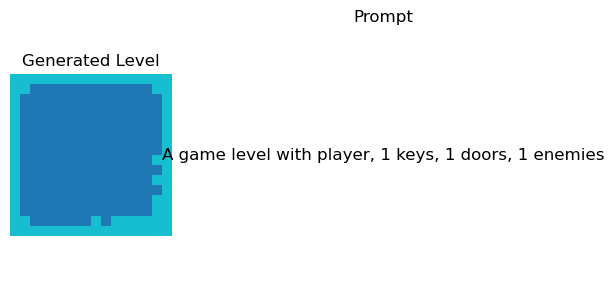

Epoch: 370, Loss: 0.6164, Accuracy: 0.7267


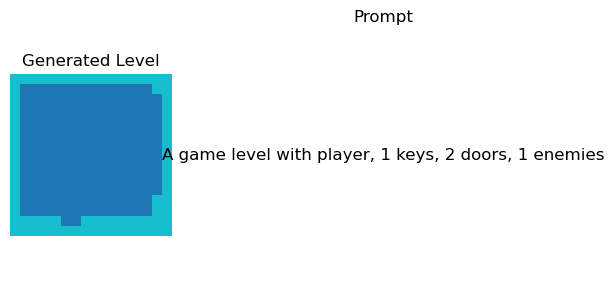

Epoch: 380, Loss: 0.6151, Accuracy: 0.7270


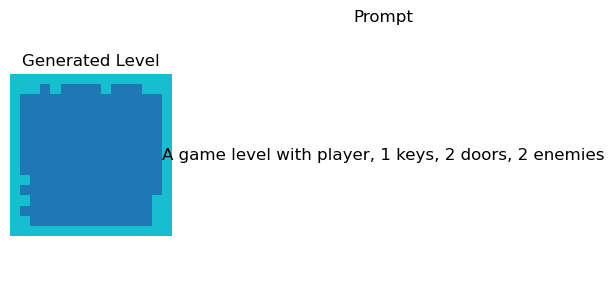

Epoch: 390, Loss: 0.6137, Accuracy: 0.7274


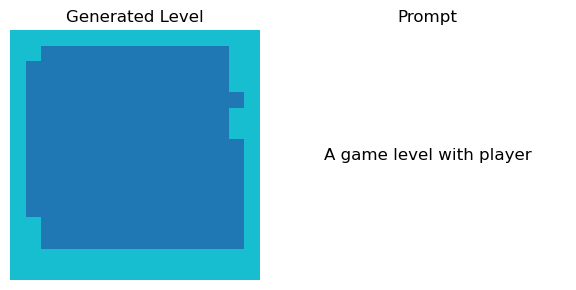

Epoch: 400, Loss: 0.6126, Accuracy: 0.7276


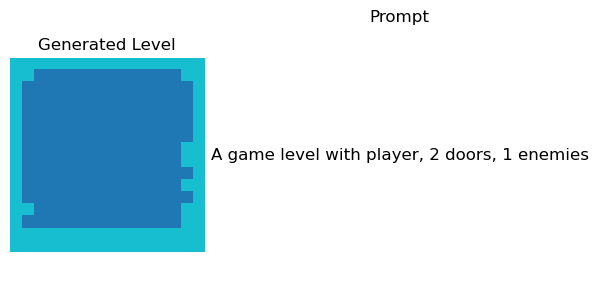

Epoch: 410, Loss: 0.6116, Accuracy: 0.7279


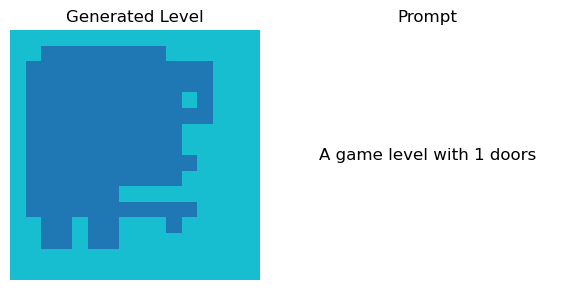

Epoch: 420, Loss: 0.6106, Accuracy: 0.7281


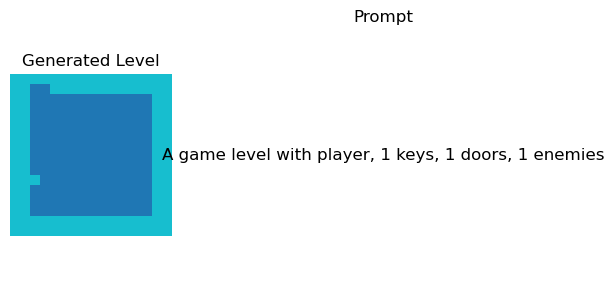

Epoch: 430, Loss: 0.6095, Accuracy: 0.7284


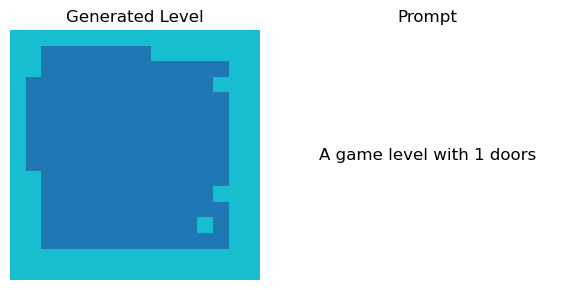

Epoch: 440, Loss: 0.6086, Accuracy: 0.7286


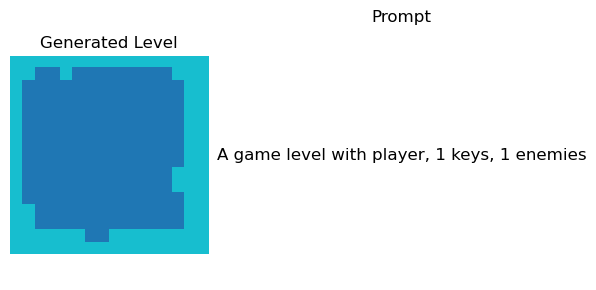

Epoch: 450, Loss: 0.6078, Accuracy: 0.7288


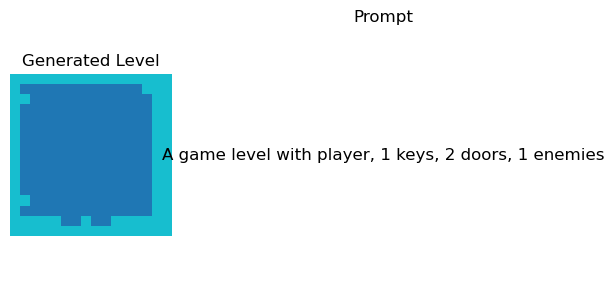

Epoch: 460, Loss: 0.6073, Accuracy: 0.7287


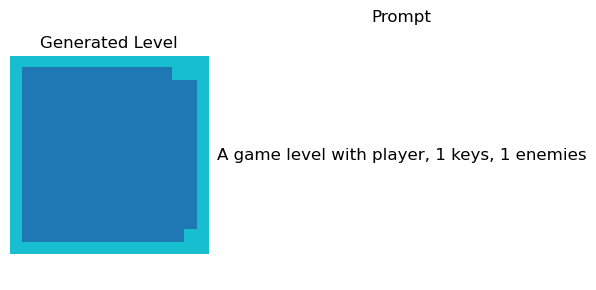

Epoch: 470, Loss: 0.6081, Accuracy: 0.7280


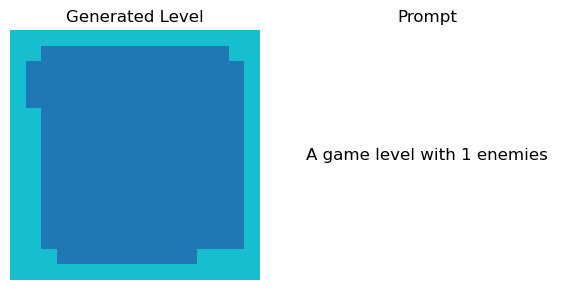

Epoch: 480, Loss: 0.6077, Accuracy: 0.7280


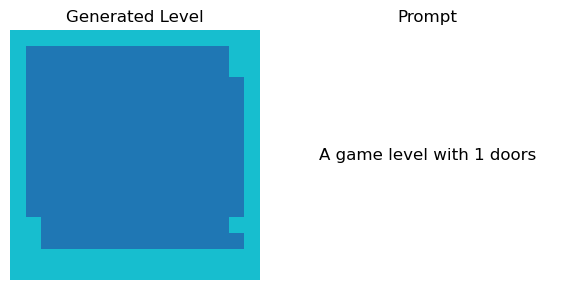

Epoch: 490, Loss: 0.6071, Accuracy: 0.7280


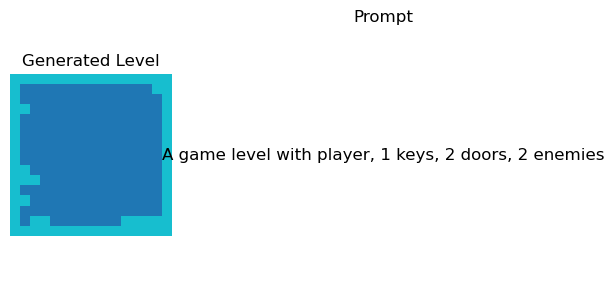

Epoch: 500, Loss: 0.6070, Accuracy: 0.7280


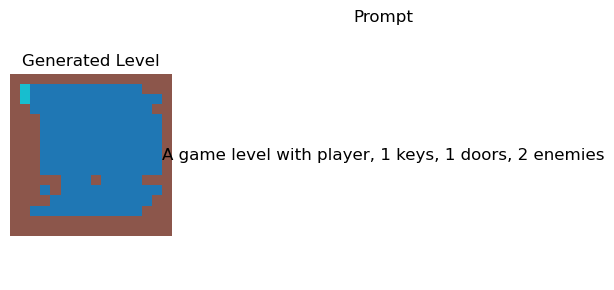

Epoch: 510, Loss: 0.6068, Accuracy: 0.7279


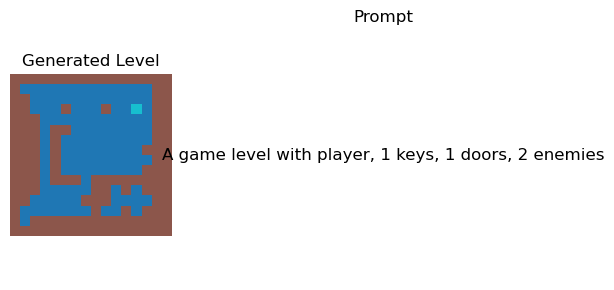

Epoch: 520, Loss: 0.6116, Accuracy: 0.7267


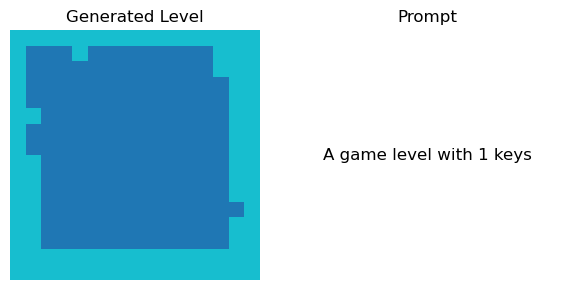

Epoch: 530, Loss: 0.6158, Accuracy: 0.7262


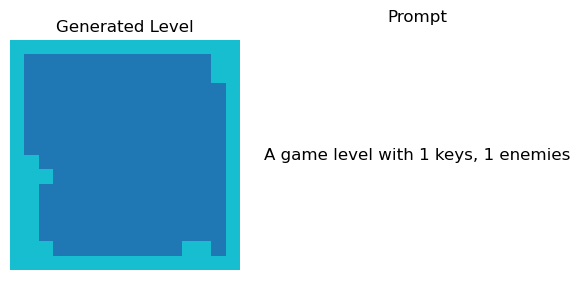

Epoch: 540, Loss: 0.6189, Accuracy: 0.7262


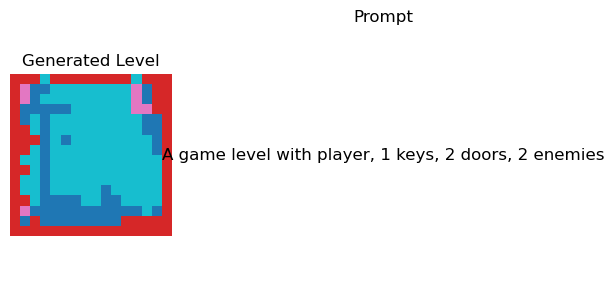

Epoch: 550, Loss: 0.6193, Accuracy: 0.7263


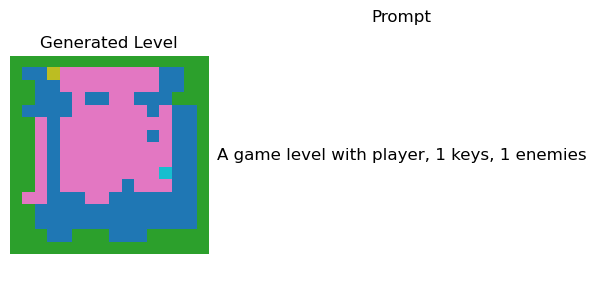

Epoch: 560, Loss: 0.6190, Accuracy: 0.7265


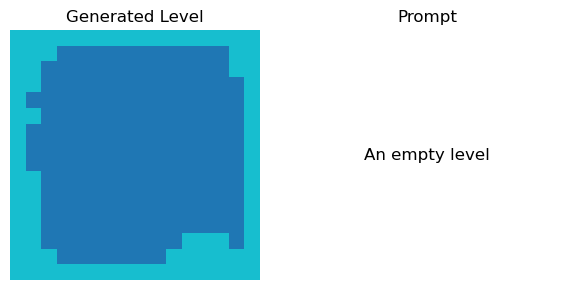

Epoch: 570, Loss: 0.6184, Accuracy: 0.7266


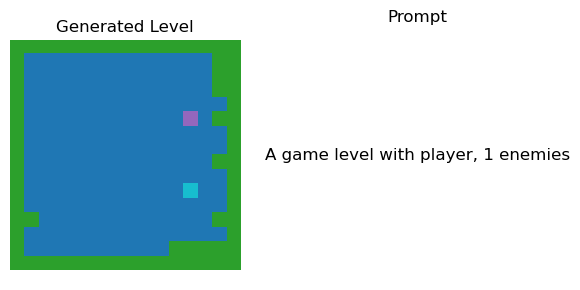

Epoch: 580, Loss: 0.6177, Accuracy: 0.7267


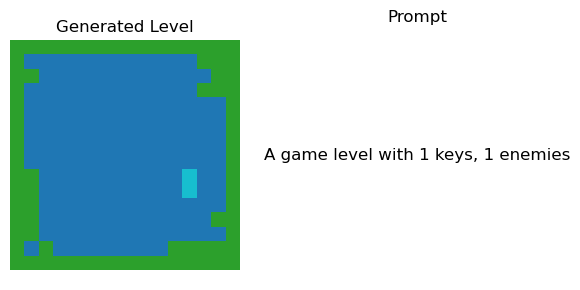

Epoch: 590, Loss: 0.6177, Accuracy: 0.7263


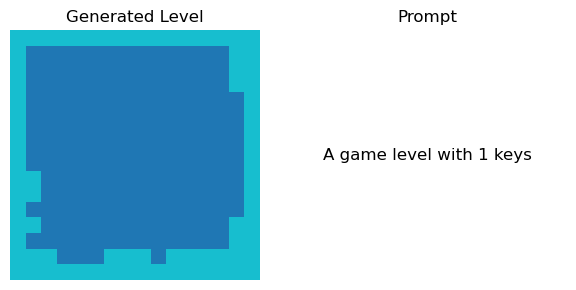

Epoch: 600, Loss: 0.6182, Accuracy: 0.7258


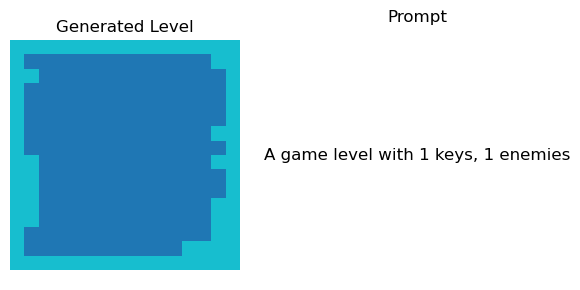

Epoch: 610, Loss: 0.6192, Accuracy: 0.7252


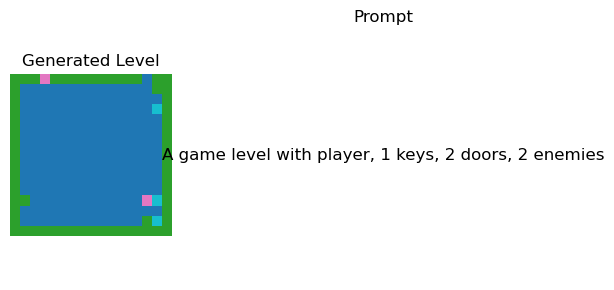

Epoch: 620, Loss: 0.6223, Accuracy: 0.7245


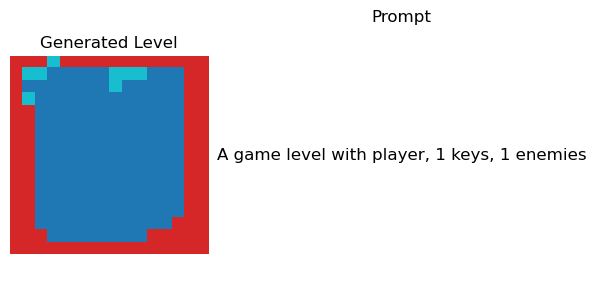

Epoch: 630, Loss: 0.6248, Accuracy: 0.7241


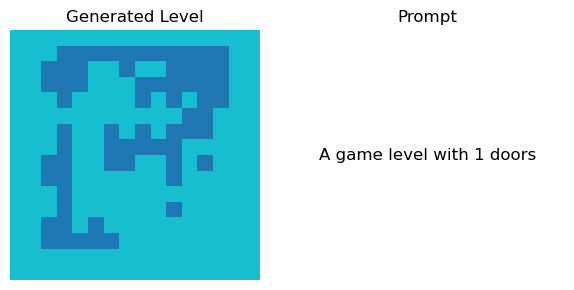

Epoch: 640, Loss: 0.6265, Accuracy: 0.7236


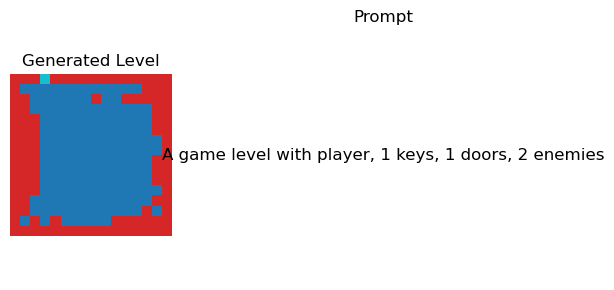

Epoch: 650, Loss: 0.6300, Accuracy: 0.7229


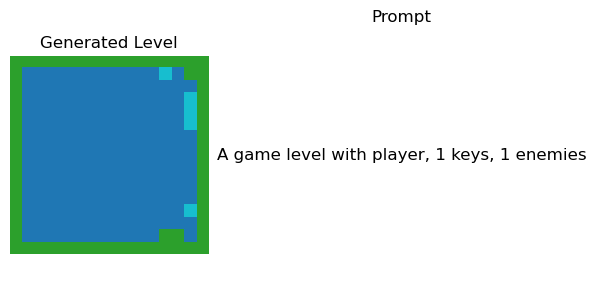

Epoch: 660, Loss: 0.6340, Accuracy: 0.7223


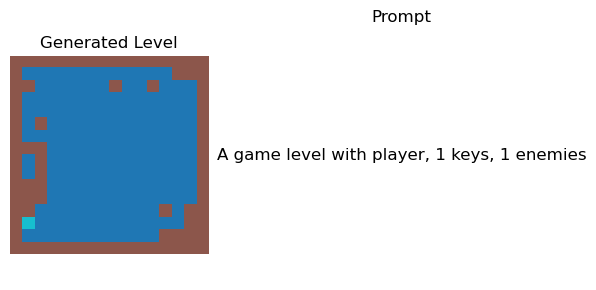

Epoch: 670, Loss: 0.6410, Accuracy: 0.7221


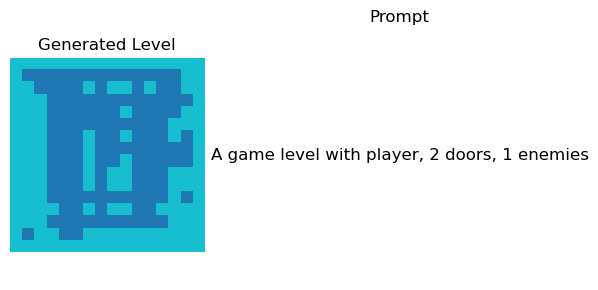

Epoch: 680, Loss: 0.6478, Accuracy: 0.7214


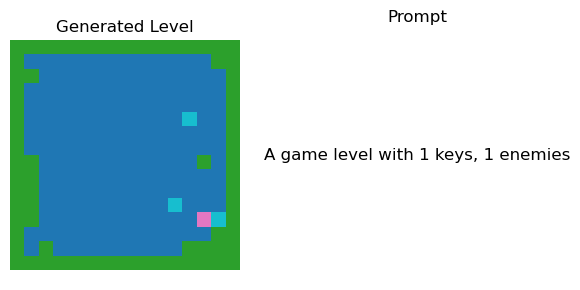

Epoch: 690, Loss: 0.6537, Accuracy: 0.7207


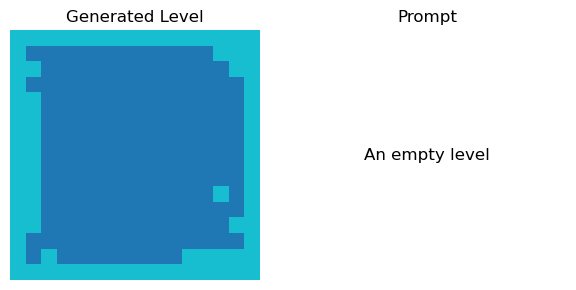

Epoch: 700, Loss: 0.6577, Accuracy: 0.7207


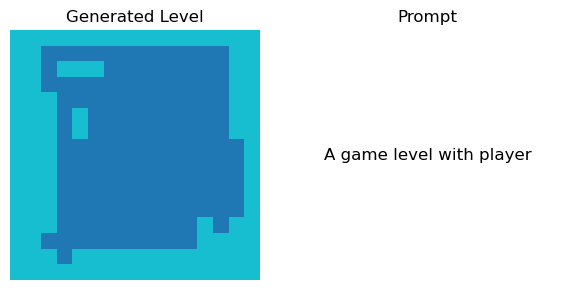

Epoch: 710, Loss: 0.6586, Accuracy: 0.7207


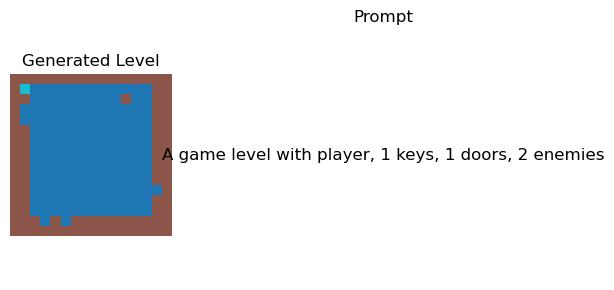

Epoch: 720, Loss: 0.6585, Accuracy: 0.7207


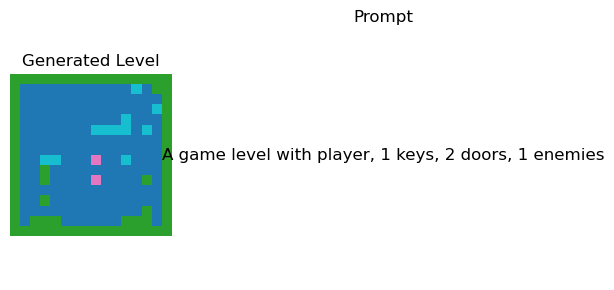

Epoch: 730, Loss: 0.6591, Accuracy: 0.7203


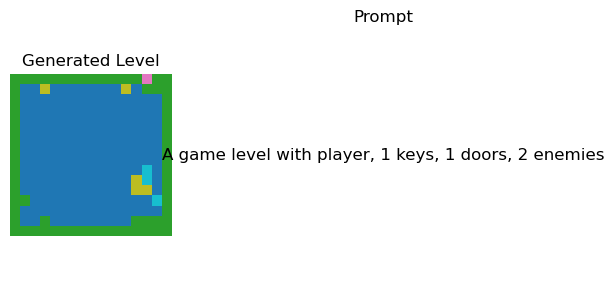

Epoch: 740, Loss: 0.6600, Accuracy: 0.7200


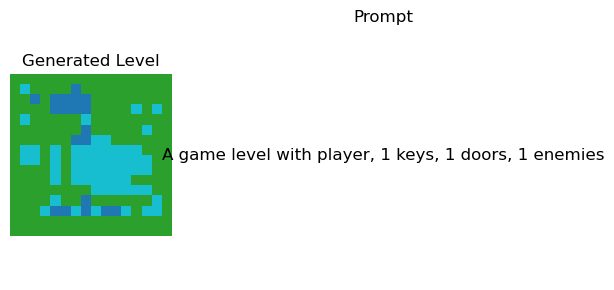

Epoch: 750, Loss: 0.6650, Accuracy: 0.7194


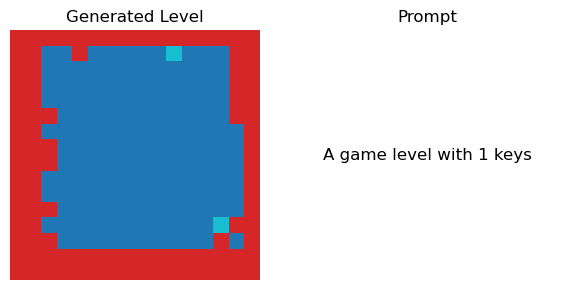

Epoch: 760, Loss: 0.6709, Accuracy: 0.7187


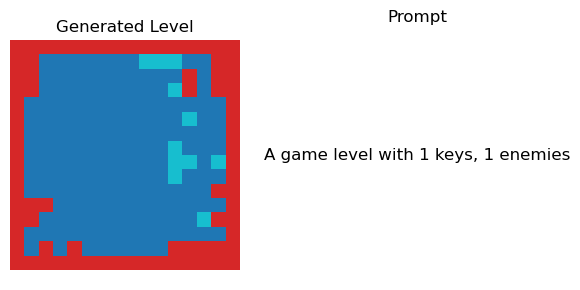

Epoch: 770, Loss: 0.6760, Accuracy: 0.7182


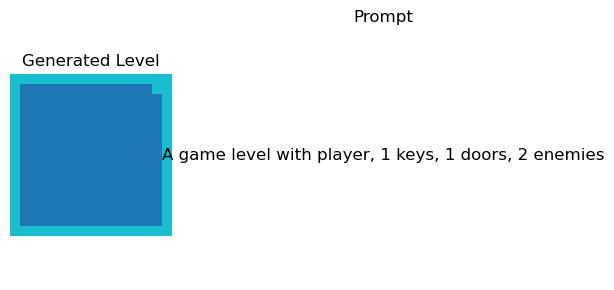

Epoch: 780, Loss: 0.6805, Accuracy: 0.7176


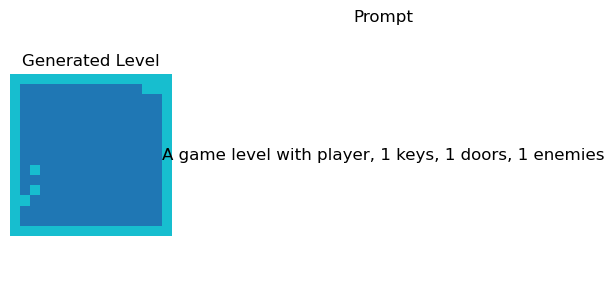

Epoch: 790, Loss: 0.6818, Accuracy: 0.7173


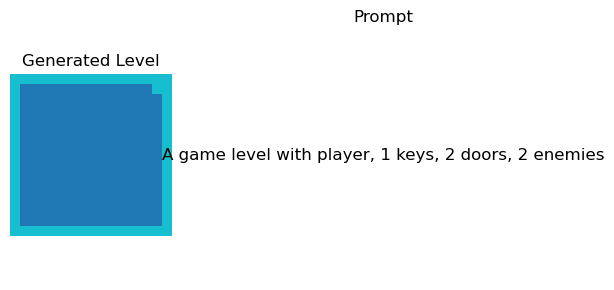

Epoch: 800, Loss: 0.6873, Accuracy: 0.7168


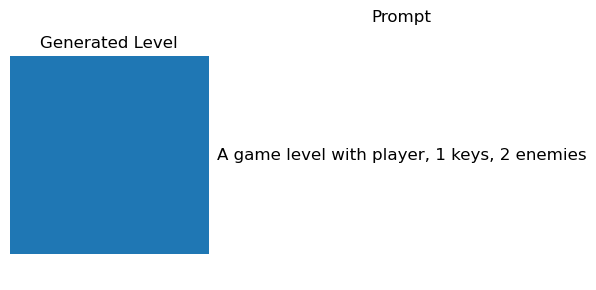

Epoch: 810, Loss: 0.6947, Accuracy: 0.7160


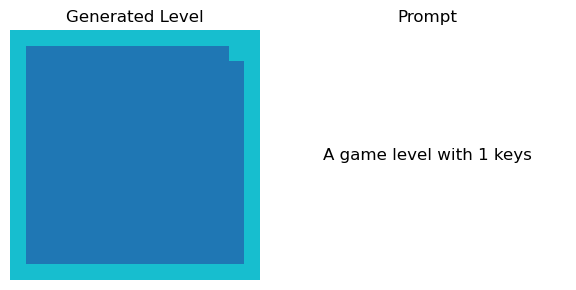

Epoch: 820, Loss: 0.7003, Accuracy: 0.7157


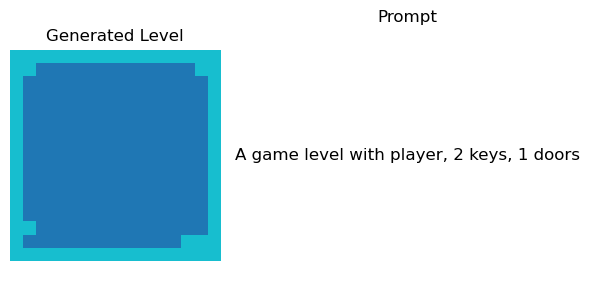

Epoch: 830, Loss: 0.7013, Accuracy: 0.7154


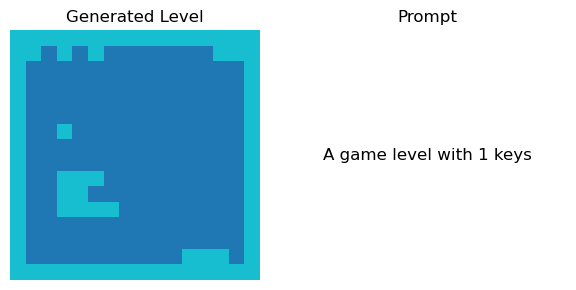

Epoch: 840, Loss: 0.7028, Accuracy: 0.7150


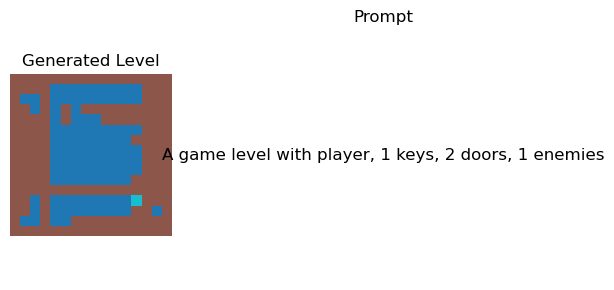

Epoch: 850, Loss: 0.7053, Accuracy: 0.7149


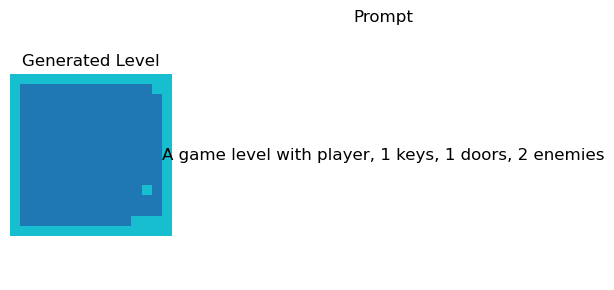

Epoch: 860, Loss: 0.7127, Accuracy: 0.7143


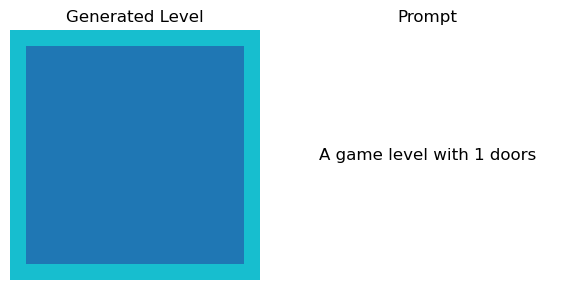

Epoch: 870, Loss: 0.7294, Accuracy: 0.7139


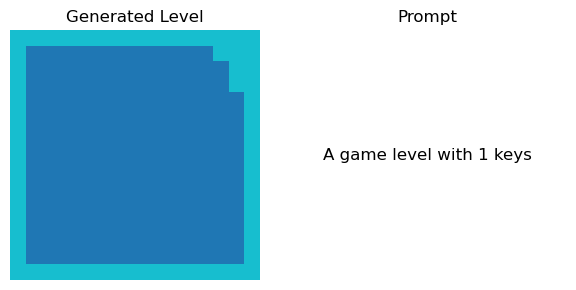

Epoch: 880, Loss: 0.7406, Accuracy: 0.7135


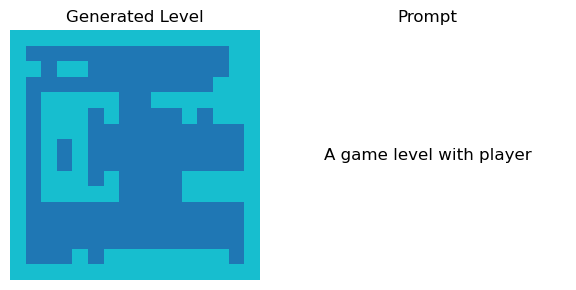

Epoch: 890, Loss: 0.7471, Accuracy: 0.7130


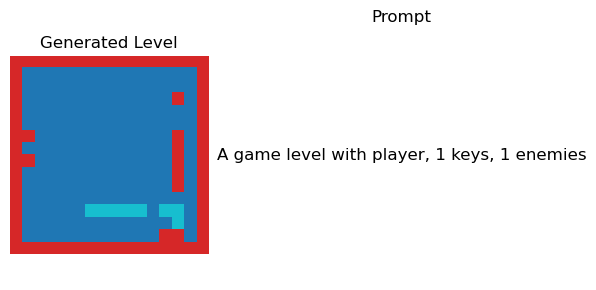

Epoch: 900, Loss: 0.7488, Accuracy: 0.7131


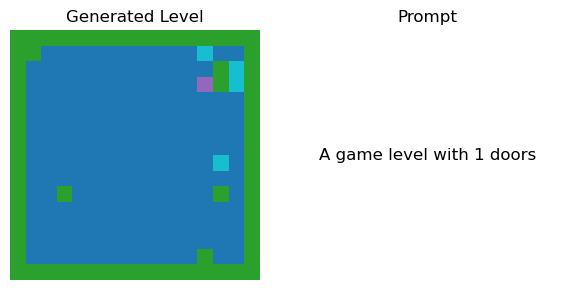

Epoch: 910, Loss: 0.7491, Accuracy: 0.7126


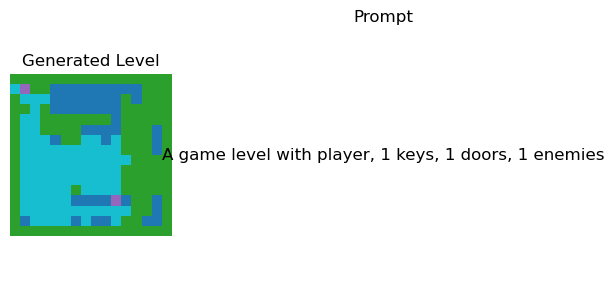

Epoch: 920, Loss: 0.7507, Accuracy: 0.7121


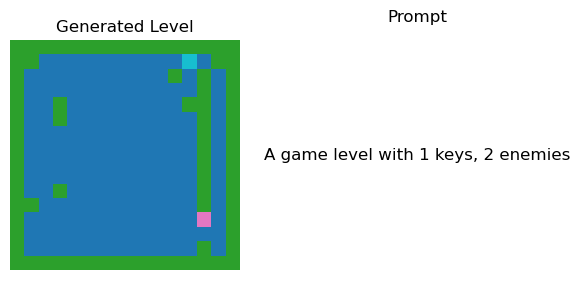

Epoch: 930, Loss: 0.7545, Accuracy: 0.7116


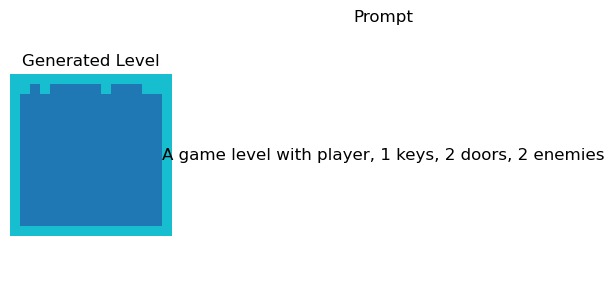

Epoch: 940, Loss: 0.7603, Accuracy: 0.7113


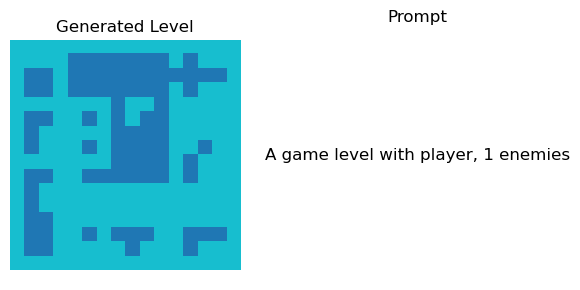

Epoch: 950, Loss: 0.7679, Accuracy: 0.7109


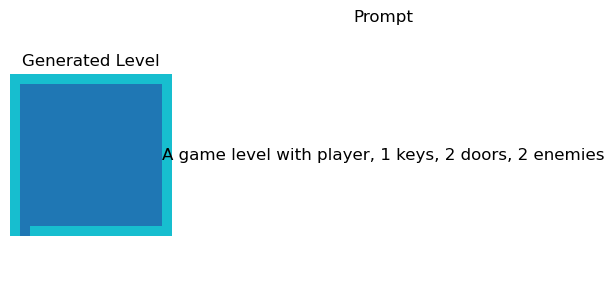

Epoch: 960, Loss: 0.7818, Accuracy: 0.7106


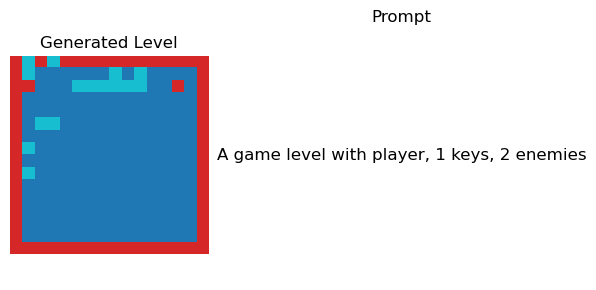

Epoch: 970, Loss: 0.7922, Accuracy: 0.7099


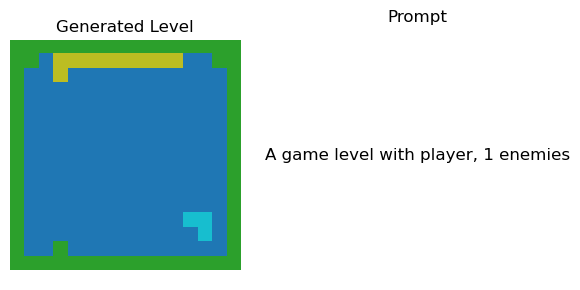

Epoch: 980, Loss: 0.8042, Accuracy: 0.7097


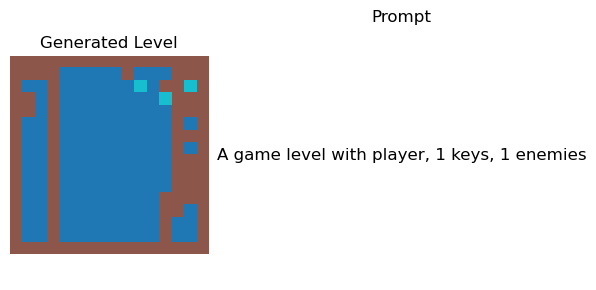

Epoch: 990, Loss: 0.8164, Accuracy: 0.7091


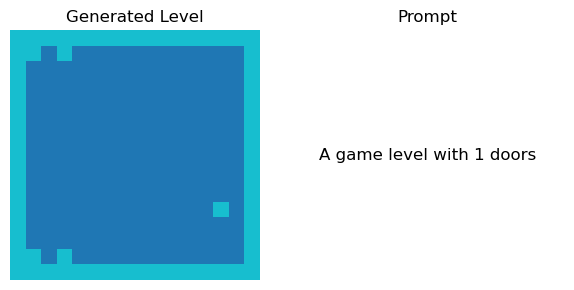

ValueError: The filename must end in `.weights.h5`. Received: filepath=models/clip_map_generator/generator_weights.h5

In [57]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Layer, Input, Dense, Reshape, Conv2D, BatchNormalization, UpSampling2D, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import pickle
import torch
from transformers import CLIPTokenizer, CLIPModel
import tensorflow as tf

# Определение слоев ConditionalInstanceNormalization и FiLMLayer
class ConditionalInstanceNormalization(Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super(ConditionalInstanceNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon

    def call(self, inputs):
        conv, scale, bias = inputs
        mean, variance = tf.nn.moments(conv, axes=[1, 2], keepdims=True)
        normalized_output = (conv - mean) / tf.sqrt(variance + self.epsilon)
        normalized_output *= scale[:, tf.newaxis, tf.newaxis]
        normalized_output += bias[:, tf.newaxis, tf.newaxis]
        return normalized_output


class FiLMLayer(Layer):
    def __init__(self):
        super(FiLMLayer, self).__init__()

    def call(self, inputs):
        ft, film_params = inputs
        runtime_shape = tf.shape(ft)
        height, width, feature_size = runtime_shape[1], runtime_shape[2], runtime_shape[3]
        film_params = tf.expand_dims(film_params, axis=[1])
        film_params = tf.expand_dims(film_params, axis=[1])
        film_params = tf.tile(film_params, [1, height, width, 1])
        gammas = film_params[:, :, :, :feature_size]
        betas = film_params[:, :, :, feature_size:]
        output = (1 + gammas) * ft + betas
        return output


# Определение основной модели
class DollarModel:
    def __init__(self, model_name, img_shape, lr, data_path, dataset_type,
                 embedding_dim=128, z_dim=5, kern_size=7, filter_count=128,
                 num_res_blocks=3, condition_type='FiLM'):

        self.embedding_dim = embedding_dim
        self.img_shape = img_shape
        self.model_name = model_name
        self.z_dim = z_dim
        self.data_path = data_path
        self.filter_count = filter_count
        self.kern_size = kern_size
        self.dataset_type = dataset_type
        self.num_res_blocks = num_res_blocks
        self.condition_type = condition_type
        self.lr = lr
        self.model_path = f'models/{self.model_name}/'
        os.makedirs(self.model_path, exist_ok=True)

        self.load_data()
        if dataset_type == 'map':
            self.num_upsample = 2
            self.gen_to_image = self.map_to_image
        else:
            self.num_upsample = 1
            self.gen_to_image = self.sprite_to_image

        self.create_model()

    def create_model(self):
        noise = Input(shape=(self.z_dim,))
        embedding = Input(shape=(self.embedding_dim,))

        x = Dense(self.filter_count * 4 * 4)(noise)
        x = Reshape((4, 4, self.filter_count))(x)

        for i in range(self.num_res_blocks):
            if i < self.num_upsample:
                x = UpSampling2D()(x)
            x1 = Conv2D(self.filter_count, self.kern_size, padding="same", activation="relu")(x)
            x1 = BatchNormalization()(x1)
            x1 = Conv2D(self.filter_count, self.kern_size, padding="same", activation="relu")(x1)
            x1 = BatchNormalization()(x1)
            x = Add()([x, x1])

            if self.condition_type == 'CIN':
                scale = Dense(self.filter_count)(embedding)
                bias = Dense(self.filter_count)(embedding)
                x = ConditionalInstanceNormalization()([x, scale, bias])
            elif self.condition_type == 'FiLM':
                film_params = Dense(2 * self.filter_count)(embedding)
                x = FiLMLayer()([x, film_params])

        x = Conv2D(self.channels, kernel_size=9, padding="same", activation="softmax")(x)
        self.generator = Model([noise, embedding], x, name="Generator")
        self.generator.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=self.lr), metrics=['accuracy'])

    def load_data(self):
        data = np.load(self.data_path, allow_pickle=True).item()
        self.images = np.array(data['images'])
        self.labels = list(data['labels'])
        self.embeddings = np.array(data['embeddings'])

        self.channels = self.images.shape[-1]

    def map_to_image(self, ascii_map):
        decoded = np.argmax(ascii_map, axis=-1)
        return Image.fromarray(decoded.astype('uint8'))

    def sprite_to_image(self, image):
        return Image.fromarray(np.argmax(image, axis=-1).astype('uint8'))


# Функция для отображения сгенерированной карты и соответствующего промта
def show_level_with_prompt(model, description_embedding, true_description):
    gen = generate_level(model, description_embedding)
    
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(gen, cmap='tab10')
    plt.title('Generated Level')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.text(0.5, 0.5, true_description, ha='center', va='center', fontsize=12)
    plt.title('Prompt')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


# Функция для генерации карты
def generate_level(model, description_embedding, num_samples=1):
    noise = np.random.normal(0, 1, (num_samples, model.z_dim))
    emb = np.repeat([description_embedding], num_samples, axis=0)
    pred = model.generator.predict([noise, emb], verbose=0)
    gen = np.argmax(pred, axis=-1)[0]
    return gen


# Тренировочная функция
def train(model, epochs=100, batch_size=32, sample_interval=10):
    for epoch in range(epochs):
        idx = np.random.randint(0, len(model.images), batch_size)
        imgs = model.images[idx]
        embs = model.embeddings[idx]
        labels = [model.labels[i] for i in idx]

        noise = np.random.normal(0, 1, (batch_size, model.z_dim))
        loss = model.generator.train_on_batch([noise, embs], imgs)

        if epoch % sample_interval == 0:
            print(f"Epoch: {epoch}, Loss: {loss[0]:.4f}, Accuracy: {loss[1]:.4f}")
            
            sample_idx = 0
            sample_emb = embs[sample_idx:sample_idx+1]
            sample_label = labels[sample_idx]
            
            show_level_with_prompt(model, sample_emb[0], sample_label)


# === Подготовка данных ===
file_path = '/Users/makssinitskiy/Desktop/MapGenerator-dev/data/game_maps_dataset.pkl'

with open(file_path, 'rb') as f:
    data = pickle.load(f)

print("Данные загружены!")


# One-hot кодирование карт
def one_hot_encode_level(level, num_classes=6):
    h, w = level.shape
    encoded = np.zeros((h, w, num_classes))
    for i in range(num_classes):
        encoded[:, :, i] = (level == i)
    return encoded

one_hot_maps = [one_hot_encode_level(np.array(m), num_classes=6) for m in data['maps']]
one_hot_maps = np.array(one_hot_maps)
print("One-hot кодирование выполнено:", one_hot_maps.shape)


# Генерация текстовых описаний
def generate_description_from_positions(positions_dict):
    elements = []
    if 'player' in positions_dict and len(positions_dict['player']) > 0:
        elements.append("player")
    if 'key' in positions_dict and len(positions_dict['key']) > 0:
        elements.append(f"{len(positions_dict['key'])} keys")
    if 'door' in positions_dict and len(positions_dict['door']) > 0:
        elements.append(f"{len(positions_dict['door'])} doors")
    if 'enemy1' in positions_dict and len(positions_dict['enemy1']) > 0:
        elements.append(f"{len(positions_dict['enemy1'])} enemies")
    return "A game level with " + ", ".join(elements) if elements else "An empty level"

descriptions = [generate_description_from_positions(pos) for pos in data['positions']]
print("Описания созданы:", len(descriptions))


# Получение эмбеддингов через правильную модель
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

def get_clip_embeddings(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = clip_model.get_text_features(**inputs)
    return outputs.numpy()

embeddings = get_clip_embeddings(descriptions)
print("Эмбеддинги получены:", embeddings.shape)


# Изменение размера до 16x16 через tf.image.resize
def resize_image(img, target_size=(16, 16)):
    return tf.image.resize(img, size=target_size).numpy()

one_hot_maps_resized = np.array([resize_image(img, (16, 16)) for img in one_hot_maps])
print("Размер изменён:", one_hot_maps_resized.shape)


# Сохранение обработанного датасета
np.save("processed_game_maps.npy", {
    "images": one_hot_maps_resized,
    "labels": descriptions,
    "embeddings": embeddings
})
print("Датасет сохранён!")

# === Обучение модели ===
input_shape = one_hot_maps_resized[0].shape
embedding_dim = embeddings.shape[1]  # должно быть 512

model = DollarModel(
    model_name="clip_map_generator",
    img_shape=input_shape,
    lr=0.0002,
    data_path="processed_game_maps.npy",
    dataset_type='map',
    embedding_dim=embedding_dim,  # Теперь корректно: 512
    z_dim=5,
    filter_count=128,
    kern_size=5,
    num_res_blocks=3,
    condition_type='FiLM'
)

print("Модель создана!")

# === Выполнение обучения ===
train(model, epochs=1000, batch_size=32, sample_interval=10)

# === Сохранение весов модели ===
model.generator.save_weights("models/clip_map_generator/generator_weights.h5")  # [[7]]

print("Веса модели сохранены!")

# === Загрузка модели ===
# Создаем новую экземпляр модели без обучения
loaded_model = DollarModel(
    model_name="clip_map_generator",
    img_shape=input_shape,
    lr=0.0002,
    data_path="processed_game_maps.npy",
    dataset_type='map',
    embedding_dim=embedding_dim,
    z_dim=5,
    filter_count=128,
    kern_size=5,
    num_res_blocks=3,
    condition_type='FiLM'
)

# Загружаем веса обученной модели
loaded_model.generator.load_weights("models/clip_map_generator/generator_weights.h5")  # [[7]]

print("Модель загружена!")

# === Инференс ===
new_description = "A game level with 2 keys and 1 door"
new_embedding = get_clip_embeddings([new_description])[0]

show_level_with_prompt(loaded_model, new_embedding, new_description)  # [[4]]

Веса модели сохранены!


/opt/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 70 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Модель загружена!


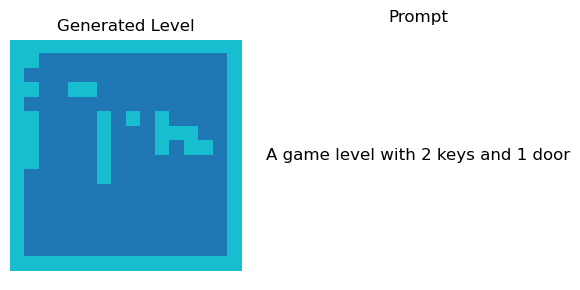

In [56]:
# === Сохранение весов модели ===
model.generator.save_weights("weights.weights.h5") # [[7]]

print("Веса модели сохранены!")

# === Загрузка модели ===
# Создаем новую экземпляр модели без обучения
loaded_model = DollarModel(
    model_name="clip_map_generator",
    img_shape=input_shape,
    lr=0.0002,
    data_path="processed_game_maps.npy",
    dataset_type='map',
    embedding_dim=embedding_dim,
    z_dim=5,
    filter_count=128,
    kern_size=5,
    num_res_blocks=3,
    condition_type='FiLM'
)

# Загружаем веса обученной модели
loaded_model.generator.load_weights("weights.weights.h5")  # [[7]]

print("Модель загружена!")

# === Инференс ===
new_description = "A game level with 2 keys and 1 door"
new_embedding = get_clip_embeddings([new_description])[0]

show_level_with_prompt(loaded_model, new_embedding, new_description)  # [[4]]

Данные загружены!
One-hot кодирование выполнено: (1000, 14, 14, 6)
Описания созданы: 1000
Эмбеддинги получены: (1000, 512)
Размер изменён: (1000, 16, 16, 6)
Датасет сохранён!
Модель создана!
Epoch: 0, Loss: 3.8412, Accuracy: 0.1592


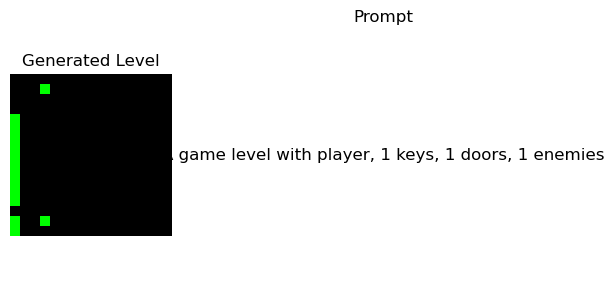

Epoch: 10, Loss: 1.4443, Accuracy: 0.5956


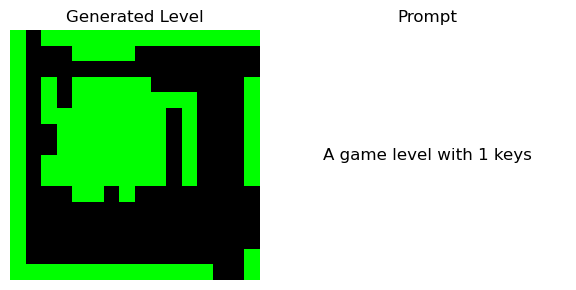

Epoch: 20, Loss: 1.1825, Accuracy: 0.6404


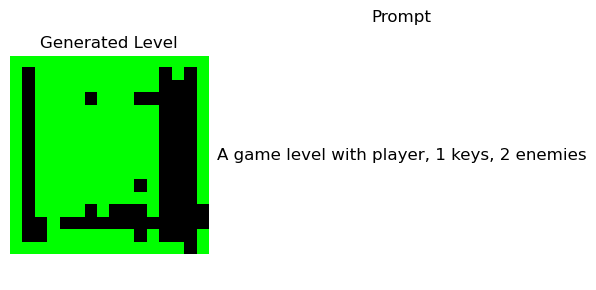

Epoch: 30, Loss: 1.0373, Accuracy: 0.6583


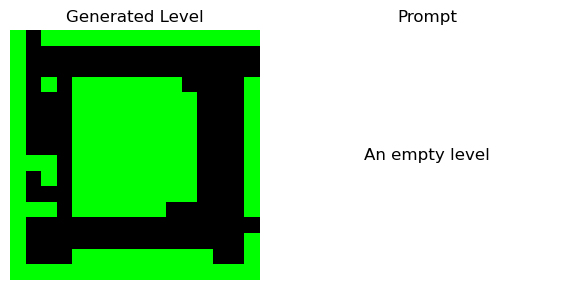

Epoch: 40, Loss: 0.9473, Accuracy: 0.6706


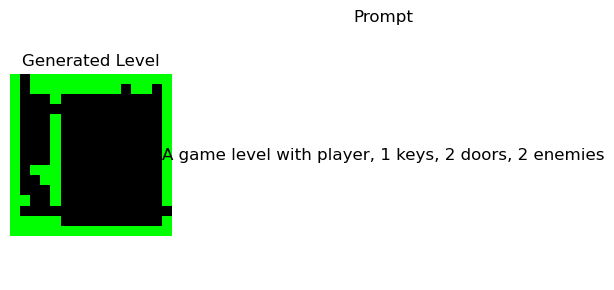

Epoch: 50, Loss: 0.8865, Accuracy: 0.6794


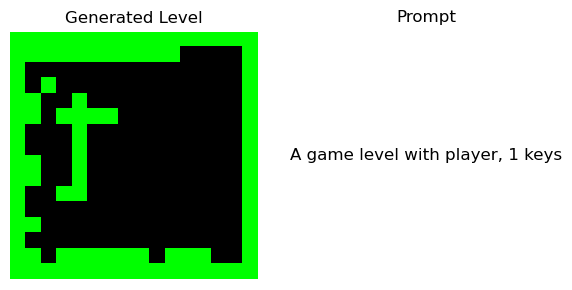

Epoch: 60, Loss: 0.8425, Accuracy: 0.6856


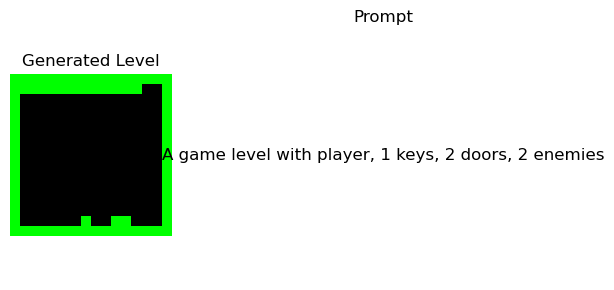

Epoch: 70, Loss: 0.8086, Accuracy: 0.6905


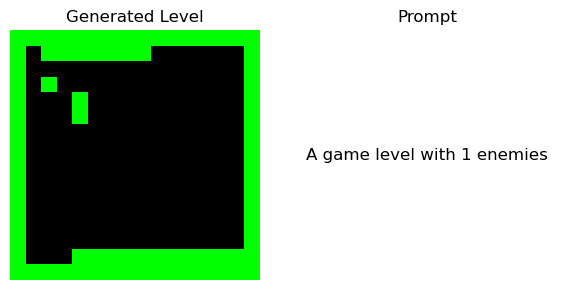

Epoch: 80, Loss: 0.7830, Accuracy: 0.6948


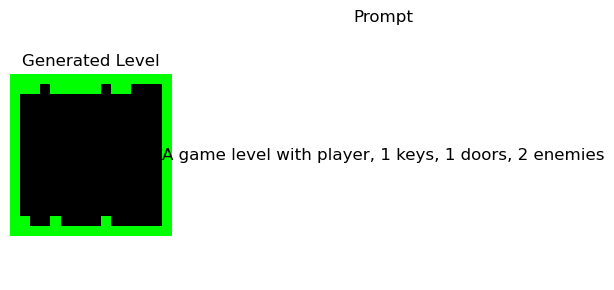

Epoch: 90, Loss: 0.7622, Accuracy: 0.6979


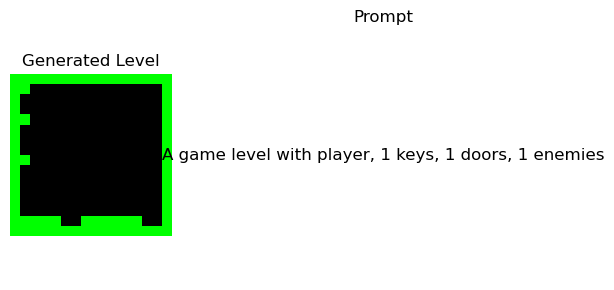

Веса модели сохранены!
Модель загружена!


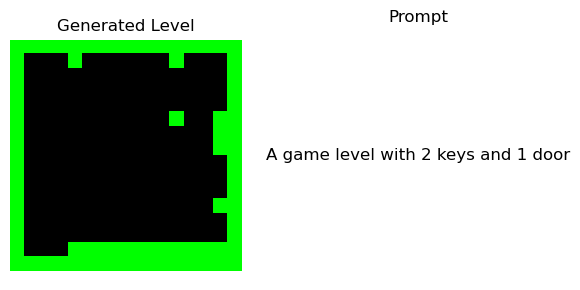

In [64]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Layer, Input, Dense, Reshape, Conv2D, BatchNormalization, UpSampling2D, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import pickle
import torch
from transformers import CLIPTokenizer, CLIPModel
import tensorflow as tf
from PIL import Image
from matplotlib.colors import ListedColormap  # [[8]]

# Определение слоев ConditionalInstanceNormalization и FiLMLayer
class ConditionalInstanceNormalization(Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super(ConditionalInstanceNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon

    def call(self, inputs):
        conv, scale, bias = inputs
        mean, variance = tf.nn.moments(conv, axes=[1, 2], keepdims=True)
        normalized_output = (conv - mean) / tf.sqrt(variance + self.epsilon)
        normalized_output *= scale[:, tf.newaxis, tf.newaxis]
        normalized_output += bias[:, tf.newaxis, tf.newaxis]
        return normalized_output


class FiLMLayer(Layer):
    def __init__(self):
        super(FiLMLayer, self).__init__()

    def call(self, inputs):
        ft, film_params = inputs
        runtime_shape = tf.shape(ft)
        height, width, feature_size = runtime_shape[1], runtime_shape[2], runtime_shape[3]
        film_params = tf.expand_dims(film_params, axis=[1])
        film_params = tf.expand_dims(film_params, axis=[1])
        film_params = tf.tile(film_params, [1, height, width, 1])
        gammas = film_params[:, :, :, :feature_size]
        betas = film_params[:, :, :, feature_size:]
        output = (1 + gammas) * ft + betas
        return output


# Определение основной модели
class DollarModel:
    def __init__(self, model_name, img_shape, lr, data_path, dataset_type,
                 embedding_dim=128, z_dim=5, kern_size=7, filter_count=128,
                 num_res_blocks=3, condition_type='FiLM'):

        self.embedding_dim = embedding_dim
        self.img_shape = img_shape
        self.model_name = model_name
        self.z_dim = z_dim
        self.data_path = data_path
        self.filter_count = filter_count
        self.kern_size = kern_size
        self.dataset_type = dataset_type
        self.num_res_blocks = num_res_blocks
        self.condition_type = condition_type
        self.lr = lr
        self.model_path = f'models/{self.model_name}/'
        os.makedirs(self.model_path, exist_ok=True)

        self.load_data()
        if dataset_type == 'map':
            self.num_upsample = 2
            self.gen_to_image = self.map_to_image
        else:
            self.num_upsample = 1
            self.gen_to_image = self.sprite_to_image

        self.create_model()

    def create_model(self):
        noise = Input(shape=(self.z_dim,))
        embedding = Input(shape=(self.embedding_dim,))

        x = Dense(self.filter_count * 4 * 4)(noise)
        x = Reshape((4, 4, self.filter_count))(x)

        for i in range(self.num_res_blocks):
            if i < self.num_upsample:
                x = UpSampling2D()(x)
            x1 = Conv2D(self.filter_count, self.kern_size, padding="same", activation="relu")(x)
            x1 = BatchNormalization()(x1)
            x1 = Conv2D(self.filter_count, self.kern_size, padding="same", activation="relu")(x1)
            x1 = BatchNormalization()(x1)
            x = Add()([x, x1])

            if self.condition_type == 'CIN':
                scale = Dense(self.filter_count)(embedding)
                bias = Dense(self.filter_count)(embedding)
                x = ConditionalInstanceNormalization()([x, scale, bias])
            elif self.condition_type == 'FiLM':
                film_params = Dense(2 * self.filter_count)(embedding)
                x = FiLMLayer()([x, film_params])

        x = Conv2D(self.channels, kernel_size=9, padding="same", activation="softmax")(x)
        self.generator = Model([noise, embedding], x, name="Generator")
        self.generator.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=self.lr), metrics=['accuracy'])

    def load_data(self):
        data = np.load(self.data_path, allow_pickle=True).item()
        self.images = np.array(data['images'])
        self.labels = list(data['labels'])
        self.embeddings = np.array(data['embeddings'])

        self.channels = self.images.shape[-1]

    def map_to_image(self, ascii_map):
        decoded = np.argmax(ascii_map, axis=-1)
        return Image.fromarray(decoded.astype('uint8'))

    def sprite_to_image(self, image):
        return Image.fromarray(np.argmax(image, axis=-1).astype('uint8'))


# Функция для отображения сгенерированной карты и соответствующего промта
def show_level_with_prompt(model, description_embedding, true_description):
    gen = generate_level(model, description_embedding)
    
    # Создаем пользовательскую палитру цветов
    custom_cmap = ListedColormap([
        [0.0, 0.0, 0.0, 1.0],   # 0 - Черный (враг)
        [1.0, 0.0, 0.0, 1.0],   # 1 - Красный (дверь)
        [1.0, 1.0, 0.0, 1.0],   # 2 - Желтый (ключ)
        [0.0, 0.0, 1.0, 1.0],   # 3 - Синий (игрок)
        [0.5, 0.5, 0.5, 1.0],   # 4 - Серый (пусто/фон)
        [0.0, 1.0, 0.0, 1.0]    # 5 - Зеленый (другой объект)
    ])
    
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(gen, cmap=custom_cmap)
    plt.title('Generated Level')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.text(0.5, 0.5, true_description, ha='center', va='center', fontsize=12)
    plt.title('Prompt')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


# Функция для генерации карты
def generate_level(model, description_embedding, num_samples=1):
    noise = np.random.normal(0, 1, (num_samples, model.z_dim))
    emb = np.repeat([description_embedding], num_samples, axis=0)
    pred = model.generator.predict([noise, emb], verbose=0)
    gen = np.argmax(pred, axis=-1)[0]
    return gen


# Тренировочная функция
def train(model, epochs=100, batch_size=32, sample_interval=10):
    for epoch in range(epochs):
        idx = np.random.randint(0, len(model.images), batch_size)
        imgs = model.images[idx]
        embs = model.embeddings[idx]
        labels = [model.labels[i] for i in idx]

        noise = np.random.normal(0, 1, (batch_size, model.z_dim))
        loss = model.generator.train_on_batch([noise, embs], imgs)

        if epoch % sample_interval == 0:
            print(f"Epoch: {epoch}, Loss: {loss[0]:.4f}, Accuracy: {loss[1]:.4f}")
            
            sample_idx = 0
            sample_emb = embs[sample_idx:sample_idx+1]
            sample_label = labels[sample_idx]
            
            show_level_with_prompt(model, sample_emb[0], sample_label)


# === Подготовка данных ===
file_path = '/Users/makssinitskiy/Desktop/MapGenerator-dev/data/game_maps_dataset.pkl'

with open(file_path, 'rb') as f:
    data = pickle.load(f)

print("Данные загружены!")


# One-hot кодирование карт
def one_hot_encode_level(level, num_classes=6):
    h, w = level.shape
    encoded = np.zeros((h, w, num_classes))
    for i in range(num_classes):
        encoded[:, :, i] = (level == i)
    return encoded

one_hot_maps = [one_hot_encode_level(np.array(m), num_classes=6) for m in data['maps']]
one_hot_maps = np.array(one_hot_maps)
print("One-hot кодирование выполнено:", one_hot_maps.shape)


# Генерация текстовых описаний
def generate_description_from_positions(positions_dict):
    elements = []
    if 'player' in positions_dict and len(positions_dict['player']) > 0:
        elements.append("player")
    if 'key' in positions_dict and len(positions_dict['key']) > 0:
        elements.append(f"{len(positions_dict['key'])} keys")
    if 'door' in positions_dict and len(positions_dict['door']) > 0:
        elements.append(f"{len(positions_dict['door'])} doors")
    if 'enemy1' in positions_dict and len(positions_dict['enemy1']) > 0:
        elements.append(f"{len(positions_dict['enemy1'])} enemies")
    return "A game level with " + ", ".join(elements) if elements else "An empty level"

descriptions = [generate_description_from_positions(pos) for pos in data['positions']]
print("Описания созданы:", len(descriptions))


# Получение эмбеддингов через правильную модель
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

def get_clip_embeddings(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = clip_model.get_text_features(**inputs)
    return outputs.numpy()

embeddings = get_clip_embeddings(descriptions)
print("Эмбеддинги получены:", embeddings.shape)


# Изменение размера до 16x16 через tf.image.resize
def resize_image(img, target_size=(16, 16)):
    return tf.image.resize(img, size=target_size).numpy()

one_hot_maps_resized = np.array([resize_image(img, (16, 16)) for img in one_hot_maps])
print("Размер изменён:", one_hot_maps_resized.shape)


# Сохранение обработанного датасета
np.save("processed_game_maps.npy", {
    "images": one_hot_maps_resized,
    "labels": descriptions,
    "embeddings": embeddings
})
print("Датасет сохранён!")

# === Обучение модели ===
input_shape = one_hot_maps_resized[0].shape
embedding_dim = embeddings.shape[1]  # должно быть 512

model = DollarModel(
    model_name="clip_map_generator",
    img_shape=input_shape,
    lr=0.0002,
    data_path="processed_game_maps.npy",
    dataset_type='map',
    embedding_dim=embedding_dim,  # Теперь корректно: 512
    z_dim=5,
    filter_count=128,
    kern_size=5,
    num_res_blocks=3,
    condition_type='FiLM'
)

print("Модель создана!")

# === Выполнение обучения ===
train(model, epochs=100, batch_size=32, sample_interval=10)

# === Сохранение весов модели ===
model.generator.save_weights("weights.weights.h5")  # [[7]]
print("Веса модели сохранены!")

# === Загрузка модели ===
# Создаем новую экземпляр модели без обучения
loaded_model = DollarModel(
    model_name="clip_map_generator",
    img_shape=input_shape,
    lr=0.0002,
    data_path="processed_game_maps.npy",
    dataset_type='map',
    embedding_dim=embedding_dim,
    z_dim=5,
    filter_count=128,
    kern_size=5,
    num_res_blocks=3,
    condition_type='FiLM'
)

# Загружаем веса обученной модели
loaded_model.generator.load_weights("weights.weights.h5")  # [[7]]
print("Модель загружена!")

# === Инференс ===
new_description = "A game level with 2 keys and 1 door"
new_embedding = get_clip_embeddings([new_description])[0]

show_level_with_prompt(loaded_model, new_embedding, new_description)  # [[4]]